

---


**MÁSTER UNIVERSITARIO EN DATA ANALYTICS FOR BUSINESS** | **UPF Barcelona School of Management** | **Curso 2023-2024**

**Trabajo Final de Máster**

**Título del proyecto**: Vía Segura: Análisis de datos para la seguridad vial en Barcelona

**Script**: Aprendizaje automático

**Autores**: Joel Bullich Esquerra y Pablo García Prado

**Mentora**: Alexandra Abós Ortega


---




## Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score, f1_score, accuracy_score
from xgboost import XGBClassifier

from google.colab import drive
drive.mount('/content/drive')

pd.set_option('display.max_columns', None)

Mounted at /content/drive


In [2]:
# Ruta del archivo
path = "/content/drive/MyDrive/TFM/clean_data/df_encoded.csv"

# Cargar el archivo en un DataFrame
df = pd.read_csv(path)

df.shape

(62308, 76)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62308 entries, 0 to 62307
Data columns (total 76 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Numero_expedient                 62308 non-null  object
 1   Codi_carrer                      62308 non-null  int64 
 2   Descripcio_dia_setmana           62308 non-null  int64 
 3   Any                              62308 non-null  int64 
 4   Mes_any                          62308 non-null  int64 
 5   Dia_mes                          62308 non-null  int64 
 6   Hora_dia                         62308 non-null  int64 
 7   Descripcio_torn                  62308 non-null  int64 
 8   Numero_morts                     62308 non-null  int64 
 9   Numero_lesionats_lleus           62308 non-null  int64 
 10  Numero_lesionats_greus           62308 non-null  int64 
 11  Numero_victimes                  62308 non-null  int64 
 12  Numero_vehicles_implicats       

# Primera propuesta: Indicador de la presencia de víctimas en un accidente

In [ ]:
df_classification_2 = df.copy()

#creamos una columna 'extra' para poner las etiquetas en funcion de si hay o no victimas
#será la columna que tendremos que 'predecir' en el modelo de clasificación

df_classification_2['HayVictimas'] = 0
df_classification_2.loc[(df_classification_2['Numero_victimes'] > 0), 'HayVictimas'] = 1

In [ ]:
#El primer paso es hacer un análisis del VIF, para evitar tener multicolinealidad
# vamos quitando las variables hasta que quede un VIF aceptable
X = df_classification_2.drop(columns=['Numero_victimes','Numero_expedient','HayVictimas','Numero_lesionats_lleus','Numero_lesionats_greus','Numero_morts','Les_Corts','Sant_Andreu',
                                      'Horta_Guinardo','DC_B','Any','Numero_vehicles_implicats','TP_Conductor','TP_Pasajero','TP_Peaton','TP_Desconocido','SinCausaMediata',
                                      'Hombre','TV_Automóvil','Desconocido'])

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data

,Feature,VIF
0,Codi_carrer,2.711109
1,Descripcio_dia_setmana,4.882135
2,Mes_any,4.251202
3,Dia_mes,3.961143
4,Hora_dia,8.918704
5,Descripcio_torn,9.737155
6,Eixample,2.450723
7,Sant_Marti,1.572777
8,Sants_Montjuic,1.505157
9,Sarria_Sant-Gervasi,1.494775


In [ ]:
#definimos ya el modelo de clasificación
X = df_classification_2.drop(columns=['Numero_victimes', 'Numero_expedient', 'HayVictimas', 'Numero_lesionats_lleus', 'Numero_lesionats_greus', 'Numero_morts', 'Les_Corts', 'Sant_Andreu',
                                      'Horta_Guinardo', 'DC_B', 'Any', 'Numero_vehicles_implicats', 'TP_Conductor', 'TP_Pasajero', 'TP_Peaton', 'TP_Desconocido', 'SinCausaMediata',
                                      'Hombre', 'TV_Automóvil','Desconocido'])


y = df_classification_2['HayVictimas']

#separacion de train-test 80-20%

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Usaremos un XG Boost (se han comprobado otros algorimtos y funcionan peor, asi que nos quedamos con este)
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#primero sacaremos las métricas generales

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

#y, a continuación, las métricas para cada uno de los subset de train y test, por separado

# recall y F1-score para los datos de entrenamiento
train_recall = recall_score(y_train, model.predict(X_train))
train_f1score = f1_score(y_train, model.predict(X_train))

#recall y F1-score para los datos de prueba
test_recall = recall_score(y_test, model.predict(X_test))
test_f1score = f1_score(y_test, model.predict(X_test))

print(f"Metrics train:\n\tAccuracy score: {accuracy_score(model.predict(X_train),y_train):.4f}\n\tRecall: {train_recall:.4f}\n\tF1-score: {train_f1score:.4f}")
print(f"Metrics test:\n\tAccuracy score: {accuracy_score(model.predict(X_test),y_test):.4f}\n\tRecall: {test_recall:.4f}\n\tF1-score: {test_f1score:.4f}")

#Ahora haremos un Cross Validation para comprobar que no existiera overfitting
# Usaremos 5 folds y aplicaremos el StratifiedKFolds para asegurarnos que cada fold tiene la misma proporcion de clases (ya que nuestro dataset está desbalanceado)

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#  métricas despues del CV
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score)
}

results = cross_validate(model, X, y, cv=kf, scoring=scoring, return_train_score=True)

print(f"Metrics train (cross-validation):")
print(f"\tAccuracy score: {results['train_accuracy'].mean():.4f}")
print(f"\tRecall: {results['train_recall'].mean():.4f}")
print(f"\tF1-score: {results['train_f1_score'].mean():.4f}")

print(f"Metrics test (cross-validation):")
print(f"\tAccuracy score: {results['test_accuracy'].mean():.4f}")
print(f"\tRecall: {results['test_recall'].mean():.4f}")
print(f"\tF1-score: {results['test_f1_score'].mean():.4f}")

Accuracy: 0.9907719467180228
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       989
           1       0.99      1.00      0.99     11473

    accuracy                           0.99     12462
   macro avg       0.98      0.96      0.97     12462
weighted avg       0.99      0.99      0.99     12462

Metrics train:
	Accuracy score: 0.9975
	Recall: 0.9994
	F1-score: 0.9987
Metrics test:
	Accuracy score: 0.9908
	Recall: 0.9969
	F1-score: 0.9950
Metrics train (cross-validation):
	Accuracy score: 0.9977
	Recall: 0.9994
	F1-score: 0.9987
Metrics test (cross-validation):
	Accuracy score: 0.9917
	Recall: 0.9973
	F1-score: 0.9955


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.21867	validation_1-logloss:0.21494
[1]	validation_0-logloss:0.17897	validation_1-logloss:0.17676
[2]	validation_0-logloss:0.14948	validation_1-logloss:0.14851
[3]	validation_0-logloss:0.12299	validation_1-logloss:0.12337
[4]	validation_0-logloss:0.10398	validation_1-logloss:0.10513
[5]	validation_0-logloss:0.08966	validation_1-logloss:0.09155
[6]	validation_0-logloss:0.07815	validation_1-logloss:0.08084
[7]	validation_0-logloss:0.06577	validation_1-logloss:0.06893
[8]	validation_0-logloss:0.05302	validation_1-logloss:0.05674
[9]	validation_0-logloss:0.04459	validation_1-logloss:0.04869
[10]	validation_0-logloss:0.04011	validation_1-logloss:0.04451
[11]	validation_0-logloss:0.03728	validation_1-logloss:0.04181
[12]	validation_0-logloss:0.03368	validation_1-logloss:0.03883
[13]	validation_0-logloss:0.03208	validation_1-logloss:0.03741
[14]	validation_0-logloss:0.02974	validation_1-logloss:0.03586
[15]	validation_0-logloss:0.02876	validation_1-logloss:0.03504
[1

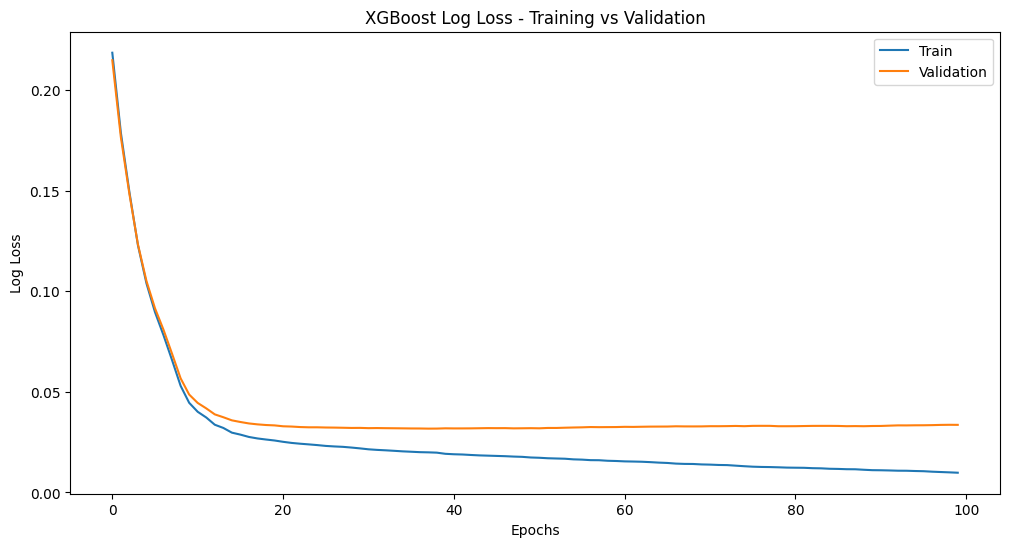

In [ ]:
#Ahora queremos graficar la curva de la funcion de perdida del algortimo, para los datos de entrenamiento y prueba

model = XGBClassifier(use_label_encoder=False)
eval_set = [(X_train, y_train), (X_test, y_test)]

# Entrenamos el modelo con el seguimiento del error de entrenamiento y validación
model.fit(X_train, y_train, eval_metric="logloss", eval_set=eval_set, verbose=True)

# métricas
results = model.evals_result()

# Graficamos las pérdidas en entrenamiento y testeo
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(12, 6))
plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
plt.plot(x_axis, results['validation_1']['logloss'], label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss - Training vs Validation')
plt.show()

La gráfica de la pérdida logarítmica (Log Loss) para el modelo XGBoost muestra las pérdidas tanto del conjunto de entrenamiento como del conjunto de validación a lo largo de las épocas. Las eépocas se refieren a cada ciclo completo de entrenamiento en el que el algoritmo de aprendizaje ve todo el conjunto de datos de entrenamiento una vez. Durante cada época, el modelo pasa por todas las muestras de entrenamiento una vez, calcula la función de pérdida (loss) y ajusta los pesos del modelo para minimizar esta pérdida.

En el gráfico podemos ver:

1. Convergencia inicial:

  Al principio, tanto la pérdida de entrenamiento como la de validación disminuyen rápidamente. Esto es esperado, ya que el modelo está aprendiendo las características básicas de los datos.

2. Diferencia entre entrenamiento y validación:

  La pérdida de entrenamiento continúa disminuyendo y se mantiene baja, lo que indica que el modelo está ajustándose bien a los datos de entrenamiento.
  La pérdida de validación también disminuye, pero no tanto como la pérdida de entrenamiento. Después de una cierta cantidad de épocas, la pérdida de validación se estabiliza e incluso parece aumentar ligeramente hacia el final.
  **Esta diferencia entre la pérdida de entrenamiento y la de validación sugiere que el modelo podría estar sobreajustándose a los datos de entrenamiento** (se mejora posteriormente al realizar pesos o SMOTE, por ejemplo). El modelo está aprendiendo patrones específicos del conjunto de entrenamiento que no generalizan bien a los datos de validación.

3. Pérdida de validación estabilizada:

  La pérdida de validación se estabiliza y no mejora significativamente después de un cierto número de épocas. Este comportamiento indica que el modelo ha alcanzado su capacidad máxima de aprendizaje sobre los datos de validación dados los parámetros actuales.

4. Posible sobreajuste (overfitting):

  La gráfica sugiere un ligero sobreajuste, especialmente hacia el final de las épocas, donde la pérdida de validación comienza a aumentar mientras la pérdida de entrenamiento sigue disminuyendo. Esto puede ser una señal de que el modelo está memorizando el ruido en los datos de entrenamiento.

Podriamos mejorar de diferentes maneras:


A. Ajuste de hiperparámetros:

  Realizar una búsqueda de hiperparámetros utilizando técnicas como Grid Search o Random Search puede ayudar a encontrar los parámetros óptimos que reduzcan la pérdida de validación.

B. Early Stopping:

  Implementar un mecanismo de "early stopping" puede prevenir el entrenamiento excesivo. Esto se detiene el entrenamiento cuando la pérdida de validación no mejora después de un número determinado de épocas.


C. Balanceo de clases:

  Dado que los datos están desbalanceados, se pueden aplicar técnicas de balanceo como SMOTE (Synthetic Minority Over-sampling Technique) puede mejorar la capacidad del modelo para predecir la clase minoritaria. (Se hará unos pasos a continuacion)



En general, el análisis sugiere que, aunque el modelo XGBoost está funcionando bien en términos de precisión y rendimiento, hay espacio para mejorar su capacidad de generalización y reducir el sobreajuste.

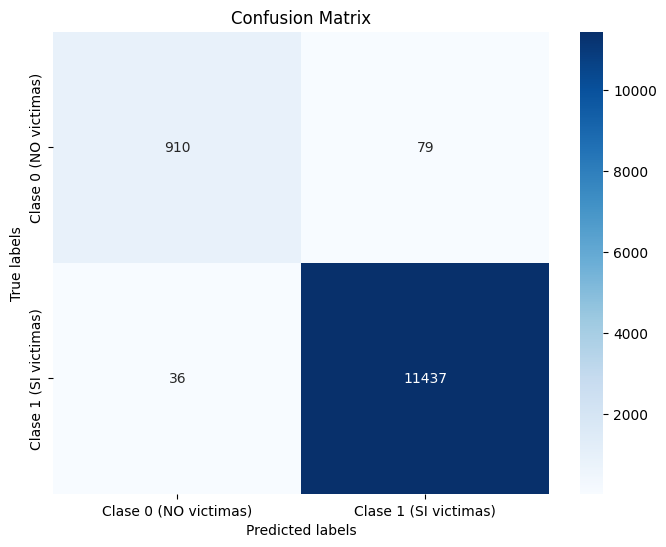

In [ ]:
#Ya podemos imprimir la matriz de confusión

y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

class_labels = ["Clase 0 (NO victimas)", "Clase 1 (SI victimas)"]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

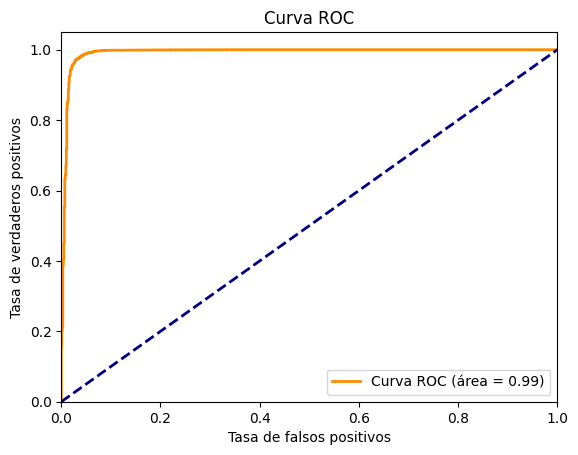

AUC: 0.9919
Accuracy: 0.9907719467180228
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       989
           1       0.99      1.00      0.99     11473

    accuracy                           0.99     12462
   macro avg       0.98      0.96      0.97     12462
weighted avg       0.99      0.99      0.99     12462



In [ ]:
#Cálculamos de la curva ROC
from sklearn.metrics import roc_curve, auc

# hacemos las predicciones de probabilidad
y_pred_proba = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {roc_auc:.4f}")

#sacamos otra vez las métricas de el modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

**Área Bajo la Curva (AUC)**: La AUC es de 0.9919, lo que es prácticamente 1. Una AUC de 1 indica un modelo perfecto que discrimina perfectamente entre las clases. El valor que nos ha dado indica que el modelo se ajusta perfectamente.

**Curva ROC:** La curva ROC muestra la tasa de verdaderos positivos (sensibilidad o recall) frente a la tasa de falsos positivos (1 - especificidad) para varios umbrales de clasificación. La curva está muy cerca del eje vertical izquierdo y del eje superior, lo que indica un alto rendimiento.


***Métricas de Clasificación***


**Accuracy**: La precisión del modelo es del 99.07%, lo cual es extremadamente alto y refleja que el modelo clasifica correctamente la mayoría de las instancias.

*Classification Report*:

1. Clase 0 (sin víctimas):

  **Precision**: 0.96 (El 96% de las predicciones de la clase 0 son correctas).

  **Recall**: 0.92 (El 92% de las instancias reales de la clase 0 son clasificadas correctamente).

  **F1-Score**: 0.94 (La media armónica de la precisión y el recall es 0.94).

 **Support**: 989 (El número de instancias reales de la clase 0).

2. Clase 1 (con víctimas):

  **Precision**: 0.99 (El 99% de las predicciones de la clase 1 son correctas).

 ** Recall**: 1.00 (El 100% de las instancias reales de la clase 1 son clasificadas correctamente).

  **F1-Score**: 0.99 (La media armónica de la precisión y el recall es 0.99).

  **Support**: 11473 (El número de instancias reales de la clase 1).
  Promedios:


**Macro avg**: La media no ponderada de la precisión, el recall y el F1-score. Esto da una idea del rendimiento del modelo en todas las clases, tratándolas por igual.

**Weighted avg**: La media ponderada de la precisión, el recall y el F1-score, donde la ponderación es el número de instancias de cada clase. Esto da una idea del rendimiento general del modelo teniendo en cuenta la distribución de la clase.


***Interpretación***

El modelo muestra un rendimiento excepcional en la clasificación de ambas clases. Sin embargo, hay un ligero desbalance en el recall de la clase 0 comparado con la clase 1, aunque sigue siendo muy alto (0.92). Esto es esperado debido al desbalance de clases en el conjunto de datos original, **pero el ajuste del parámetro scale_pos_weight podría ayudar a mitigar este problema**.

POdemos concluir que el modelo de XGBoost está funcionando de manera excelente en la clasificación de accidentes con y sin víctimas, como lo demuestra la curva ROC y las métricas de evaluación.

A continuación, nos interesa saber quñe variables (o features) son las que más importancia (o peso) tienen a la hora de clasificar los accidentes en función de si tienen o no tienen victimas. Para ello, hay que instalar la librería "shap" para sacar esos valores

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 7.3 MB/s eta 0:00:00


<ipython-input-14-748c1c6050ce>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_20_features, palette='viridis')


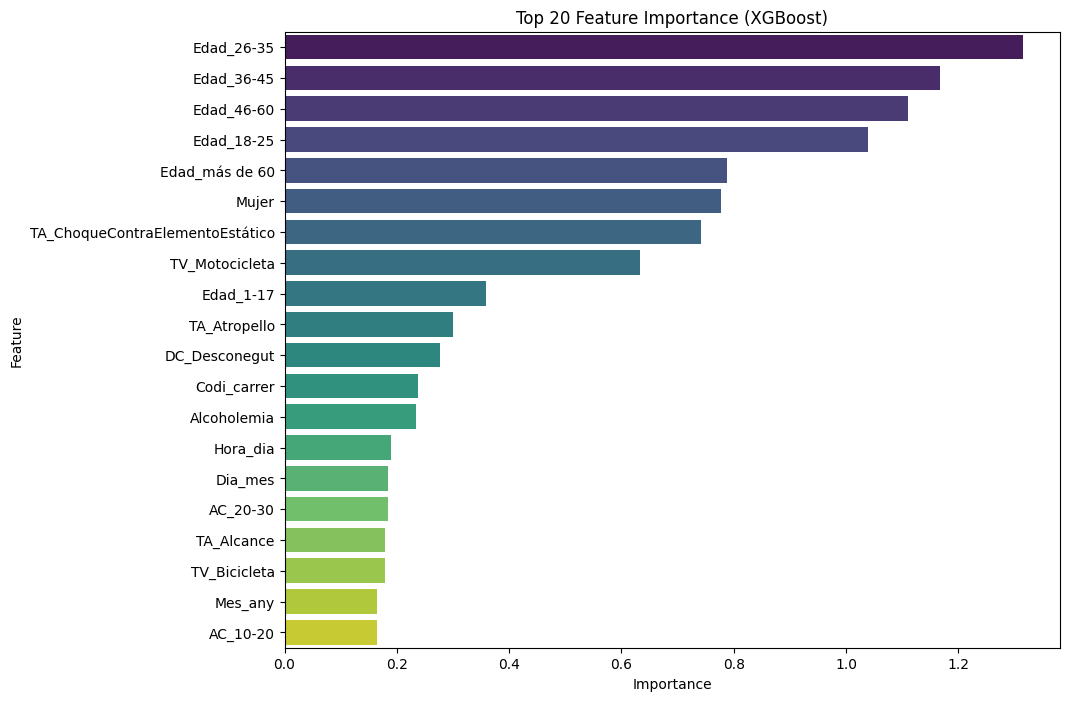

                            Feature  Importance  SHAP Value
0                        Edad_26-35    1.314553    0.552346
1                        Edad_36-45    1.166922    0.316982
2                        Edad_46-60    1.110750    0.242700
3                        Edad_18-25    1.039124    0.118596
4                    Edad_más de 60    0.788329    0.095379
5                             Mujer    0.776576    0.246099
6   TA_ChoqueContraElementoEstático    0.742075    0.252672
7                    TV_Motocicleta    0.633981    0.305379
8                         Edad_1-17    0.358570    0.062510
9                      TA_Atropello    0.299606    0.119744
10                    DC_Desconegut    0.277222    0.086151
11                      Codi_carrer    0.237731    0.044079
12                      Alcoholemia    0.234898    0.081632
13                         Hora_dia    0.189311    0.027031
14                          Dia_mes    0.184267    0.039265
15                         AC_20-30    0

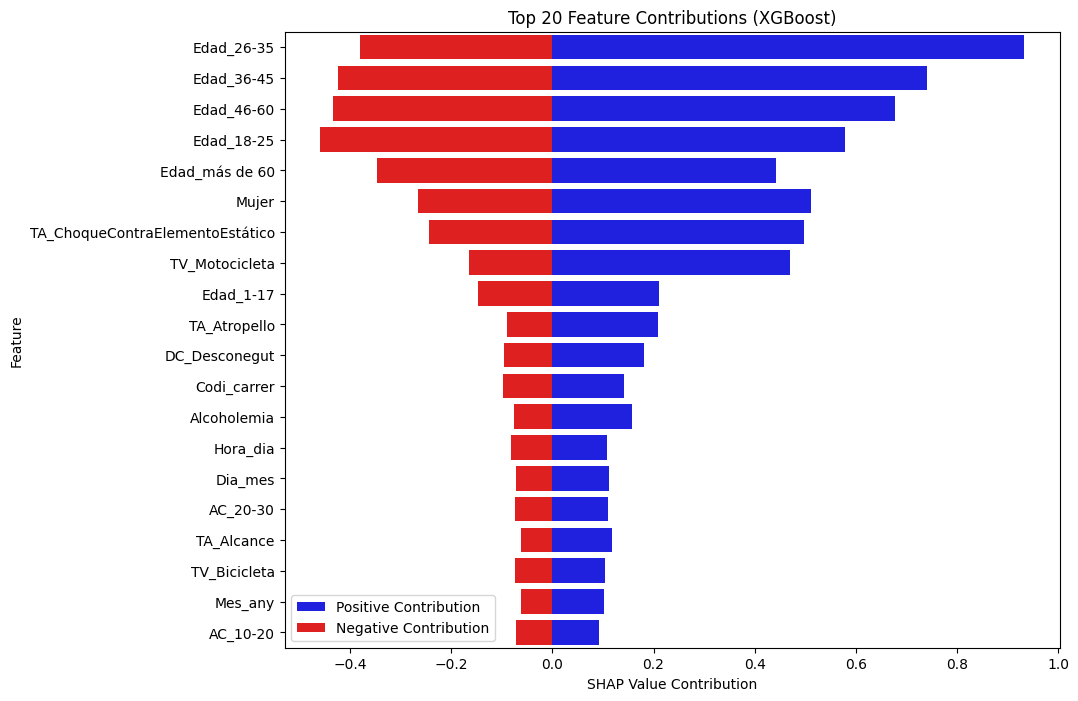

In [ ]:
import shap

#vemos el feature importance mediante el metodo "shap"

explainer = shap.Explainer(model)
shap_values = explainer(X_train)

# importancia de las características usando los valores absolutos medios de SHAP
shap_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(shap_values.values).mean(axis=0),
    'SHAP Value': shap_values.values.mean(axis=0)                   # Esto es la media de los valores SHAP para obtener la contribución
})

shap_importance = shap_importance.sort_values(by='Importance', ascending=False)

# Limitamos al top20
top_20_features = shap_importance.head(20).reset_index(drop=True)

# 1r gráfico
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_20_features, palette='viridis')
plt.title('Top 20 Feature Importance (XGBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


print(top_20_features)

# Ahora vemos desglosado la contribucion positiva y negaiva
shap_contributions = pd.DataFrame({
    'Feature': X_train.columns,
    'Positive Contribution': np.where(shap_values.values > 0, shap_values.values, 0).mean(axis=0),
    'Negative Contribution': np.where(shap_values.values < 0, shap_values.values, 0).mean(axis=0)
})

shap_contributions = shap_contributions[shap_contributions['Feature'].isin(top_20_features['Feature'])]

# Ordenamos de acuerdo a la importancia
shap_contributions = shap_contributions.set_index('Feature').loc[top_20_features['Feature']].reset_index()

# 2o grafico
plt.figure(figsize=(10, 8))
sns.barplot(x='Positive Contribution', y='Feature', data=shap_contributions, label='Positive Contribution', color='b')
sns.barplot(x='Negative Contribution', y='Feature', data=shap_contributions, label='Negative Contribution', color='r')
plt.title('Top 20 Feature Contributions (XGBoost)')
plt.xlabel('SHAP Value Contribution')
plt.ylabel('Feature')
plt.legend()
plt.show()


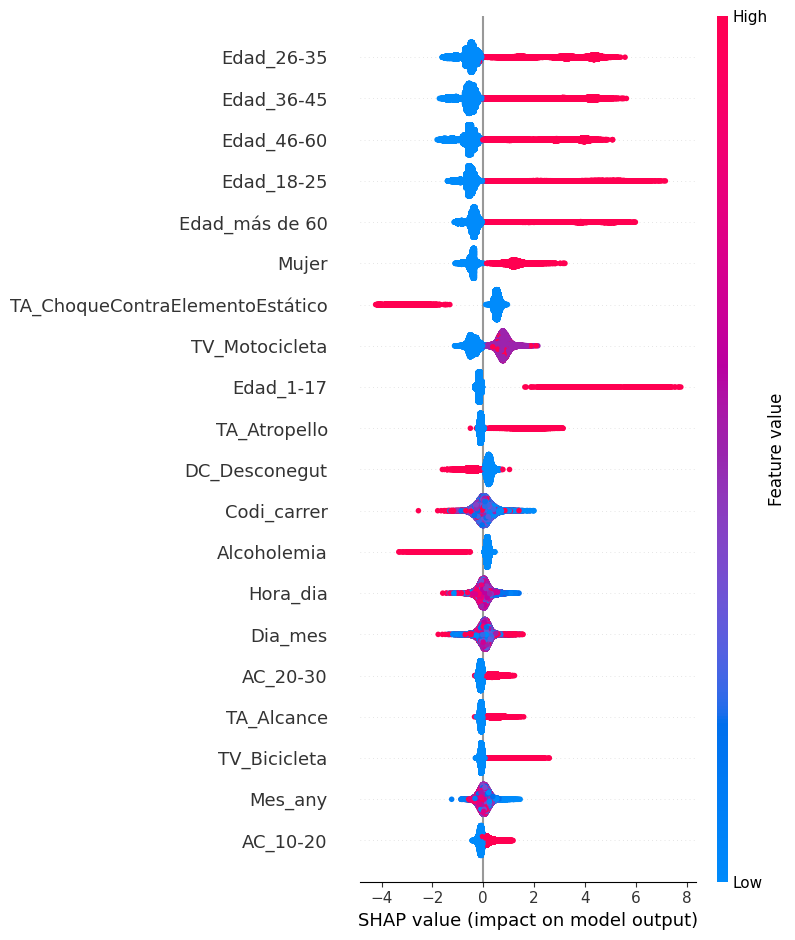

In [ ]:
#hacemos el grafico SHapley
explainer = shap.Explainer(model)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)


Hay un desbalanceo claro de las clases, ya que la mayoría son accidentes con victimas. A continuación, se procederá a aplicar una técnica SMOTE (pversampling para la clase minoritaria) y Undersampling para la clase mayoritaria. Esta técnica deberia ayudar a balancear mejor los resultados de las métricas para ambas clases.

In [ ]:
df_classification_2.HayVictimas.value_counts()

HayVictimas
1    57127
0     5181
Name: count, dtype: int64

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Definimos los métodos de oversampling y undersampling
#SMOTE lo que hace es generar nuevas muestras sintéticas hasta que la clase minoritaria tenga la mitad (50%) del tamaño de la clase mayoritaria.
#ajustamos a 50%
over = SMOTE(sampling_strategy=0.5)
#RandomUnderSampler reduce la clase mayoritaria hasta que sea 80% del tamaño de la clase minoritaria.
#ajustamos al 80%
under = RandomUnderSampler(sampling_strategy=0.8)

# lo ponemos en un pipeline
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# ejecutamos el pipeline a los datos de entrenamiento
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

# Volvemos a entrenar el modelo con los datos resampleados y hacemos la predicción
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.9902904830685283
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       989
           1       0.99      1.00      0.99     11473

    accuracy                           0.99     12462
   macro avg       0.97      0.96      0.97     12462
weighted avg       0.99      0.99      0.99     12462



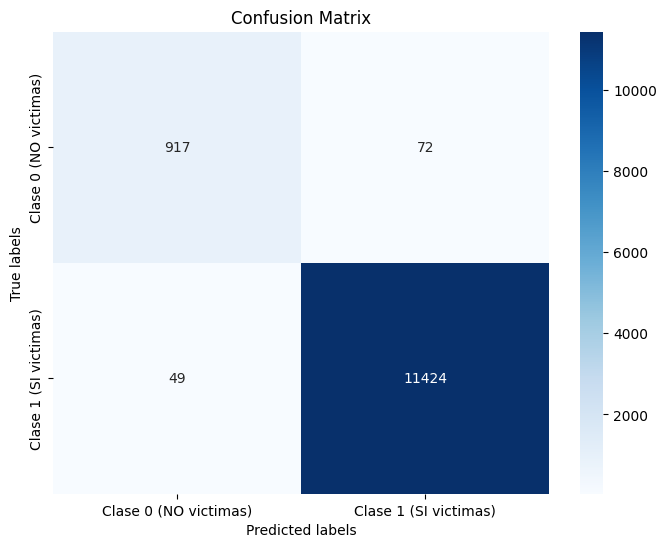

In [ ]:

conf_matrix = confusion_matrix(y_test, y_pred)

class_labels = ["Clase 0 (NO victimas)", "Clase 1 (SI victimas)"]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Cabe mencionar que cada vez que se ejecuta el codigo puede cambiar muy ligeramente los casos clasificados (por ejemplo, en la memoria consta un total de 52 casos mal clasificados como NO victimas, cuando esta vez nos ha dado 49).

AUn asi, y como conclusión, el hecho de haber aplicado un SMOTE y un Undersampler no nos ha dado mucho mejores métricas respecto la primera version del modelo. Mejora ligeramente el recall pero empeora en casos mal clasificados de la clase 1 (la mas grave, ya que se trata de victimas reales).

A continuación, en el apartado de "Otras técnicas de balanceo (descartadas)", se muestra las diferentes opciones que se han probado para intentar mejorar las métricas del modelo mendiante otras ténicas de balanceo de datos para las clases 0 y 1. Se han descartado debido a la incapacidad de mejorar dichas métricas, si bien es cierto que consiguen mejorar las curvas de pérdida a medida que aumentan las epochs (o veces que se analiza el total de los datos por parte del algoritmo).

###Otras técnicas de balanceo (descartadas)

La primera opción seguida fue ajustando el parámetro scale_pos_weight del algortimo.

Accuracy: 0.9872412132883968
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       989
           1       1.00      0.99      0.99     11473

    accuracy                           0.99     12462
   macro avg       0.95      0.97      0.96     12462
weighted avg       0.99      0.99      0.99     12462

Metrics train:
	Accuracy score: 0.9939
	Recall: 0.9934
	F1-score: 0.9966
Metrics test:
	Accuracy score: 0.9872
	Recall: 0.9908
	F1-score: 0.9931


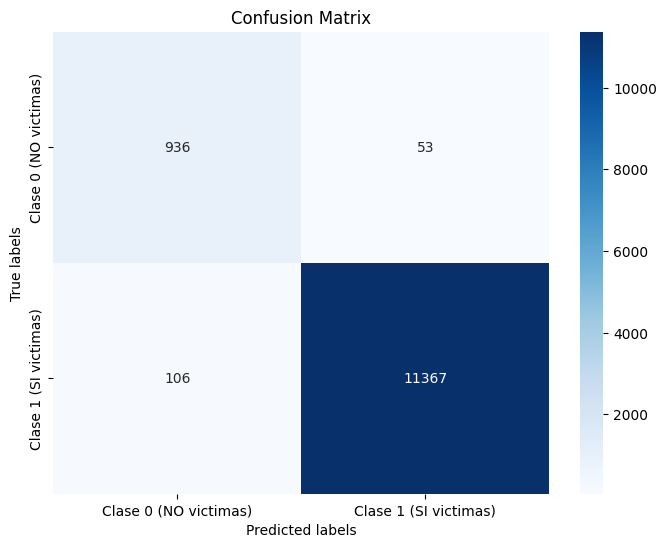

In [ ]:
#AJUSTE DEL PARÁMETRO Y RECÁLCULO DEL XGBOOST
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight)
model.fit(X_train, y_train)

# predicciones
y_pred = model.predict(X_test)

# MÉTRICAS DEL MODELO
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

#CROSS-VALIDATION (Overfitting?)
train_recall = recall_score(y_train, model.predict(X_train))
train_f1score = f1_score(y_train, model.predict(X_train))

test_recall = recall_score(y_test, model.predict(X_test))
test_f1score = f1_score(y_test, model.predict(X_test))

print(f"Metrics train:\n\tAccuracy score: {accuracy_score(model.predict(X_train),y_train):.4f}\n\tRecall: {train_recall:.4f}\n\tF1-score: {train_f1score:.4f}")
print(f"Metrics test:\n\tAccuracy score: {accuracy_score(model.predict(X_test),y_test):.4f}\n\tRecall: {test_recall:.4f}\n\tF1-score: {test_f1score:.4f}")

#MATRIZ DE CONFUSIÓN
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

class_labels = ["Clase 0 (NO victimas)", "Clase 1 (SI victimas)"]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

[0]	validation_0-logloss:0.45452	validation_1-logloss:0.45475
[1]	validation_0-logloss:0.32229	validation_1-logloss:0.32257
[2]	validation_0-logloss:0.23818	validation_1-logloss:0.23843
[3]	validation_0-logloss:0.18175	validation_1-logloss:0.18232
[4]	validation_0-logloss:0.14273	validation_1-logloss:0.14332
[5]	validation_0-logloss:0.11502	validation_1-logloss:0.11585
[6]	validation_0-logloss:0.09510	validation_1-logloss:0.09609
[7]	validation_0-logloss:0.08062	validation_1-logloss:0.08187
[8]	validation_0-logloss:0.06979	validation_1-logloss:0.07108
[9]	validation_0-logloss:0.06185	validation_1-logloss:0.06321
[10]	validation_0-logloss:0.05615	validation_1-logloss:0.05774
[11]	validation_0-logloss:0.05186	validation_1-logloss:0.05360
[12]	validation_0-logloss:0.04857	validation_1-logloss:0.05027
[13]	validation_0-logloss:0.04606	validation_1-logloss:0.04802
[14]	validation_0-logloss:0.04380	validation_1-logloss:0.04618
[15]	validation_0-logloss:0.04217	validation_1-logloss:0.04471
[1

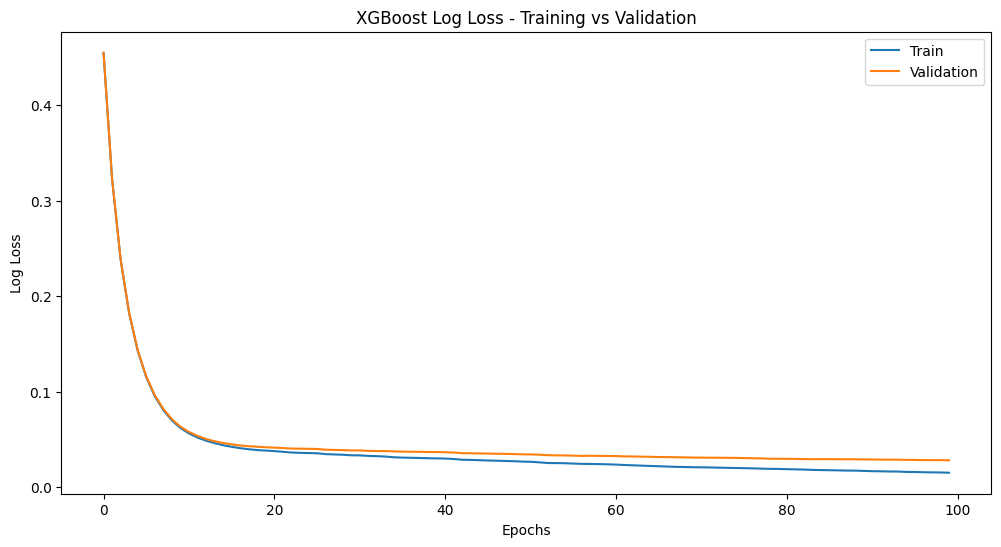

In [ ]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight)
# conjuntos de entrenamiento y validación:
eval_set = [(X_train, y_train), (X_test, y_test)]

# Entrenamos el modelo con el seguimiento del error de entrenamiento y validación
model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

# métricas
results = model.evals_result()

# Graficamos las pérdidas en entrenamiento y testeo
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(12, 6))
plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
plt.plot(x_axis, results['validation_1']['logloss'], label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss - Training vs Validation')
plt.show()

La segunda opción seguida consiste en probar de hacer oversampling unicamente. Lo que hace es generar muestras sintéticas de la clase minoritaria



Accuracy: 0.9907719467180228
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       989
           1       0.99      1.00      0.99     11473

    accuracy                           0.99     12462
   macro avg       0.98      0.96      0.97     12462
weighted avg       0.99      0.99      0.99     12462

Metrics train:
	Accuracy score: 0.9984
	Recall: 0.9991
	F1-score: 0.9984
Metrics test:
	Accuracy score: 0.9908
	Recall: 0.9967
	F1-score: 0.9950


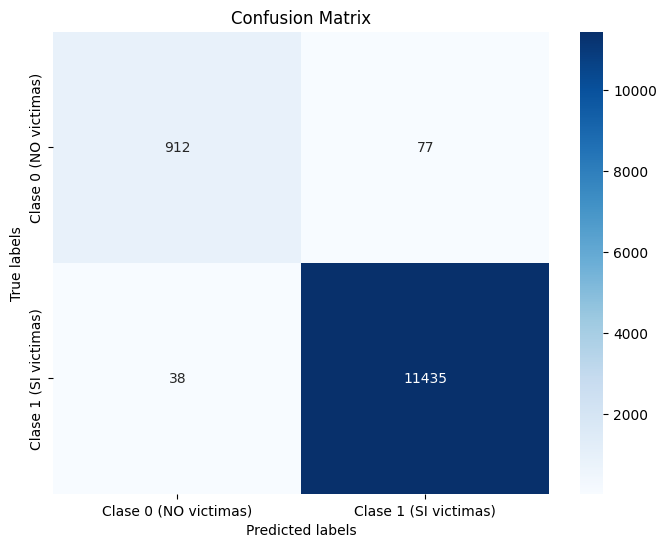

In [ ]:
from imblearn.over_sampling import SMOTE

# SMOTE para balancear las clases
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# REENTRENAMOS EL MODELO
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_res, y_res)

# predicciones
y_pred = model.predict(X_test)

# MÉTRICAS DEL MODELO
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

#CROSS-VALIDATION (Overfitting?)
train_recall = recall_score(y_res, model.predict(X_res))
train_f1score = f1_score(y_res, model.predict(X_res))

test_recall = recall_score(y_test, model.predict(X_test))
test_f1score = f1_score(y_test, model.predict(X_test))

print(f"Metrics train:\n\tAccuracy score: {accuracy_score(model.predict(X_res),y_res):.4f}\n\tRecall: {train_recall:.4f}\n\tF1-score: {train_f1score:.4f}")
print(f"Metrics test:\n\tAccuracy score: {accuracy_score(model.predict(X_test),y_test):.4f}\n\tRecall: {test_recall:.4f}\n\tF1-score: {test_f1score:.4f}")

#MATRIZ DE CONFUSIÓN
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

class_labels = ["Clase 0 (NO victimas)", "Clase 1 (SI victimas)"]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

[0]	validation_0-logloss:0.46151	validation_1-logloss:0.46136
[1]	validation_0-logloss:0.33124	validation_1-logloss:0.33099
[2]	validation_0-logloss:0.24866	validation_1-logloss:0.24898
[3]	validation_0-logloss:0.19240	validation_1-logloss:0.19271
[4]	validation_0-logloss:0.15093	validation_1-logloss:0.15159
[5]	validation_0-logloss:0.12203	validation_1-logloss:0.12280
[6]	validation_0-logloss:0.10082	validation_1-logloss:0.10180
[7]	validation_0-logloss:0.08364	validation_1-logloss:0.08465
[8]	validation_0-logloss:0.06926	validation_1-logloss:0.07055
[9]	validation_0-logloss:0.05970	validation_1-logloss:0.06126
[10]	validation_0-logloss:0.05036	validation_1-logloss:0.05232
[11]	validation_0-logloss:0.04432	validation_1-logloss:0.04661
[12]	validation_0-logloss:0.03972	validation_1-logloss:0.04205
[13]	validation_0-logloss:0.03685	validation_1-logloss:0.03942
[14]	validation_0-logloss:0.03411	validation_1-logloss:0.03699
[15]	validation_0-logloss:0.03187	validation_1-logloss:0.03482
[1

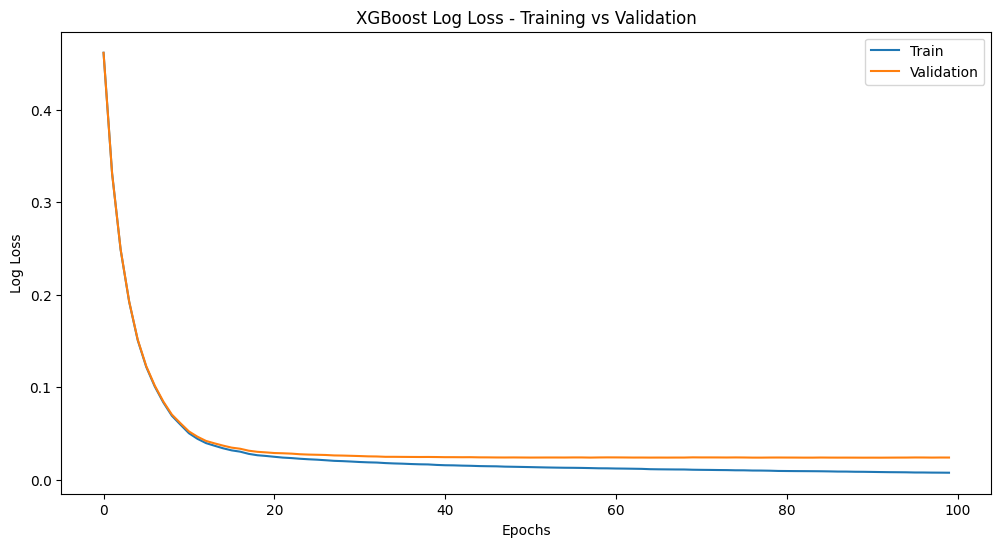

In [ ]:

# conjuntos de entrenamiento y validación:
eval_set = [(X_train, y_train), (X_test, y_test)]

# Entrenamos el modelo con el seguimiento del error de entrenamiento y validación
model.fit(X_res, y_res, eval_set=eval_set, verbose=True)

# métricas
results = model.evals_result()

# Graficamos las pérdidas en entrenamiento y testeo
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(12, 6))
plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
plt.plot(x_axis, results['validation_1']['logloss'], label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss - Training vs Validation')
plt.show()

La ultima de las opciones seguida consiste en ir haciendo undersmpling únicamente. Lo que hace es reducir el número de muestras en la clase mayoritaria de manera que se pueda equilibrar el dataset.



Accuracy: 0.9799390146043974
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.88       989
           1       1.00      0.98      0.99     11473

    accuracy                           0.98     12462
   macro avg       0.91      0.97      0.94     12462
weighted avg       0.98      0.98      0.98     12462

Metrics train:
	Accuracy score: 0.9993
	Recall: 0.9993
	F1-score: 0.9993
Metrics test:
	Accuracy score: 0.9799
	Recall: 0.9812
	F1-score: 0.9890


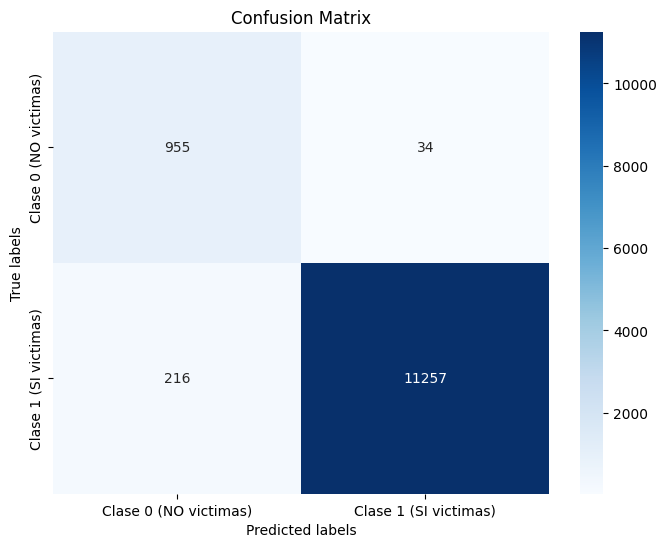

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# RandomUnderSampler para balancear las clases
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)

# Reentrenamos el modelo
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_res, y_res)

# predicciones
y_pred = model.predict(X_test)

# MÉTRICAS DEL MODELO
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

#CROSS-VALIDATION (Overfitting?)
train_recall = recall_score(y_res, model.predict(X_res))
train_f1score = f1_score(y_res, model.predict(X_res))

test_recall = recall_score(y_test, model.predict(X_test))
test_f1score = f1_score(y_test, model.predict(X_test))

print(f"Metrics train:\n\tAccuracy score: {accuracy_score(model.predict(X_res),y_res):.4f}\n\tRecall: {train_recall:.4f}\n\tF1-score: {train_f1score:.4f}")
print(f"Metrics test:\n\tAccuracy score: {accuracy_score(model.predict(X_test),y_test):.4f}\n\tRecall: {test_recall:.4f}\n\tF1-score: {test_f1score:.4f}")

#MATRIZ DE CONFUSIÓN
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

class_labels = ["Clase 0 (NO victimas)", "Clase 1 (SI victimas)"]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Este modelo funciona perfectamente en TRAIN, pero falla un poquito más en TEST

[0]	validation_0-logloss:0.45573	validation_1-logloss:0.45572
[1]	validation_0-logloss:0.32384	validation_1-logloss:0.32403
[2]	validation_0-logloss:0.24063	validation_1-logloss:0.24090
[3]	validation_0-logloss:0.18493	validation_1-logloss:0.18521
[4]	validation_0-logloss:0.14657	validation_1-logloss:0.14707
[5]	validation_0-logloss:0.11935	validation_1-logloss:0.11989
[6]	validation_0-logloss:0.09990	validation_1-logloss:0.10017
[7]	validation_0-logloss:0.08574	validation_1-logloss:0.08610
[8]	validation_0-logloss:0.07540	validation_1-logloss:0.07590
[9]	validation_0-logloss:0.06811	validation_1-logloss:0.06866
[10]	validation_0-logloss:0.06244	validation_1-logloss:0.06305
[11]	validation_0-logloss:0.05838	validation_1-logloss:0.05912
[12]	validation_0-logloss:0.05547	validation_1-logloss:0.05619
[13]	validation_0-logloss:0.05307	validation_1-logloss:0.05431
[14]	validation_0-logloss:0.05130	validation_1-logloss:0.05263
[15]	validation_0-logloss:0.05013	validation_1-logloss:0.05189
[1

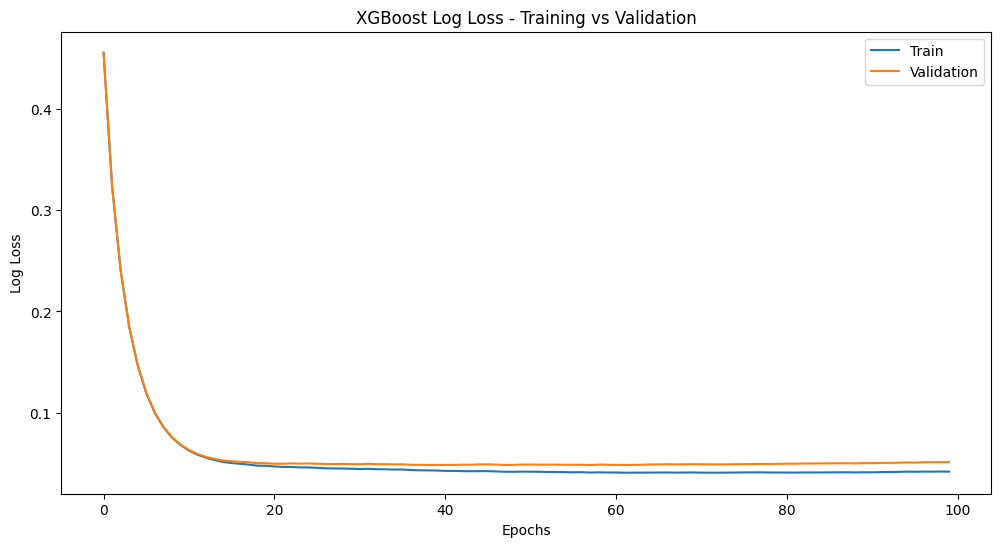

In [ ]:
# conjuntos de entrenamiento y validación:
eval_set = [(X_train, y_train), (X_test, y_test)]

# Entrenamos el modelo con el seguimiento del error de entrenamiento y validación
model.fit(X_res, y_res, eval_set=eval_set, verbose=True)

# métricas
results = model.evals_result()

# Graficamos las pérdidas en entrenamiento y testeo
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(12, 6))
plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
plt.plot(x_axis, results['validation_1']['logloss'], label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss - Training vs Validation')
plt.show()

#Segunda Propuesta: Indicador de la gravedad de un accidente

## Preprocess

In [4]:
df_classification = df.copy()

df_classification['IndGravedadAccidente'] = 0
df_classification.loc[(df_classification['Numero_morts'] > 0) | (df_classification['Numero_lesionats_greus'] > 0), 'IndGravedadAccidente'] = 1


In [5]:
df_classification = df_classification.drop(columns=['Numero_expedient', 'Any', 'Numero_morts', 'Numero_lesionats_lleus', 'Numero_lesionats_greus', 'Codi_carrer'])

## Correlaciones

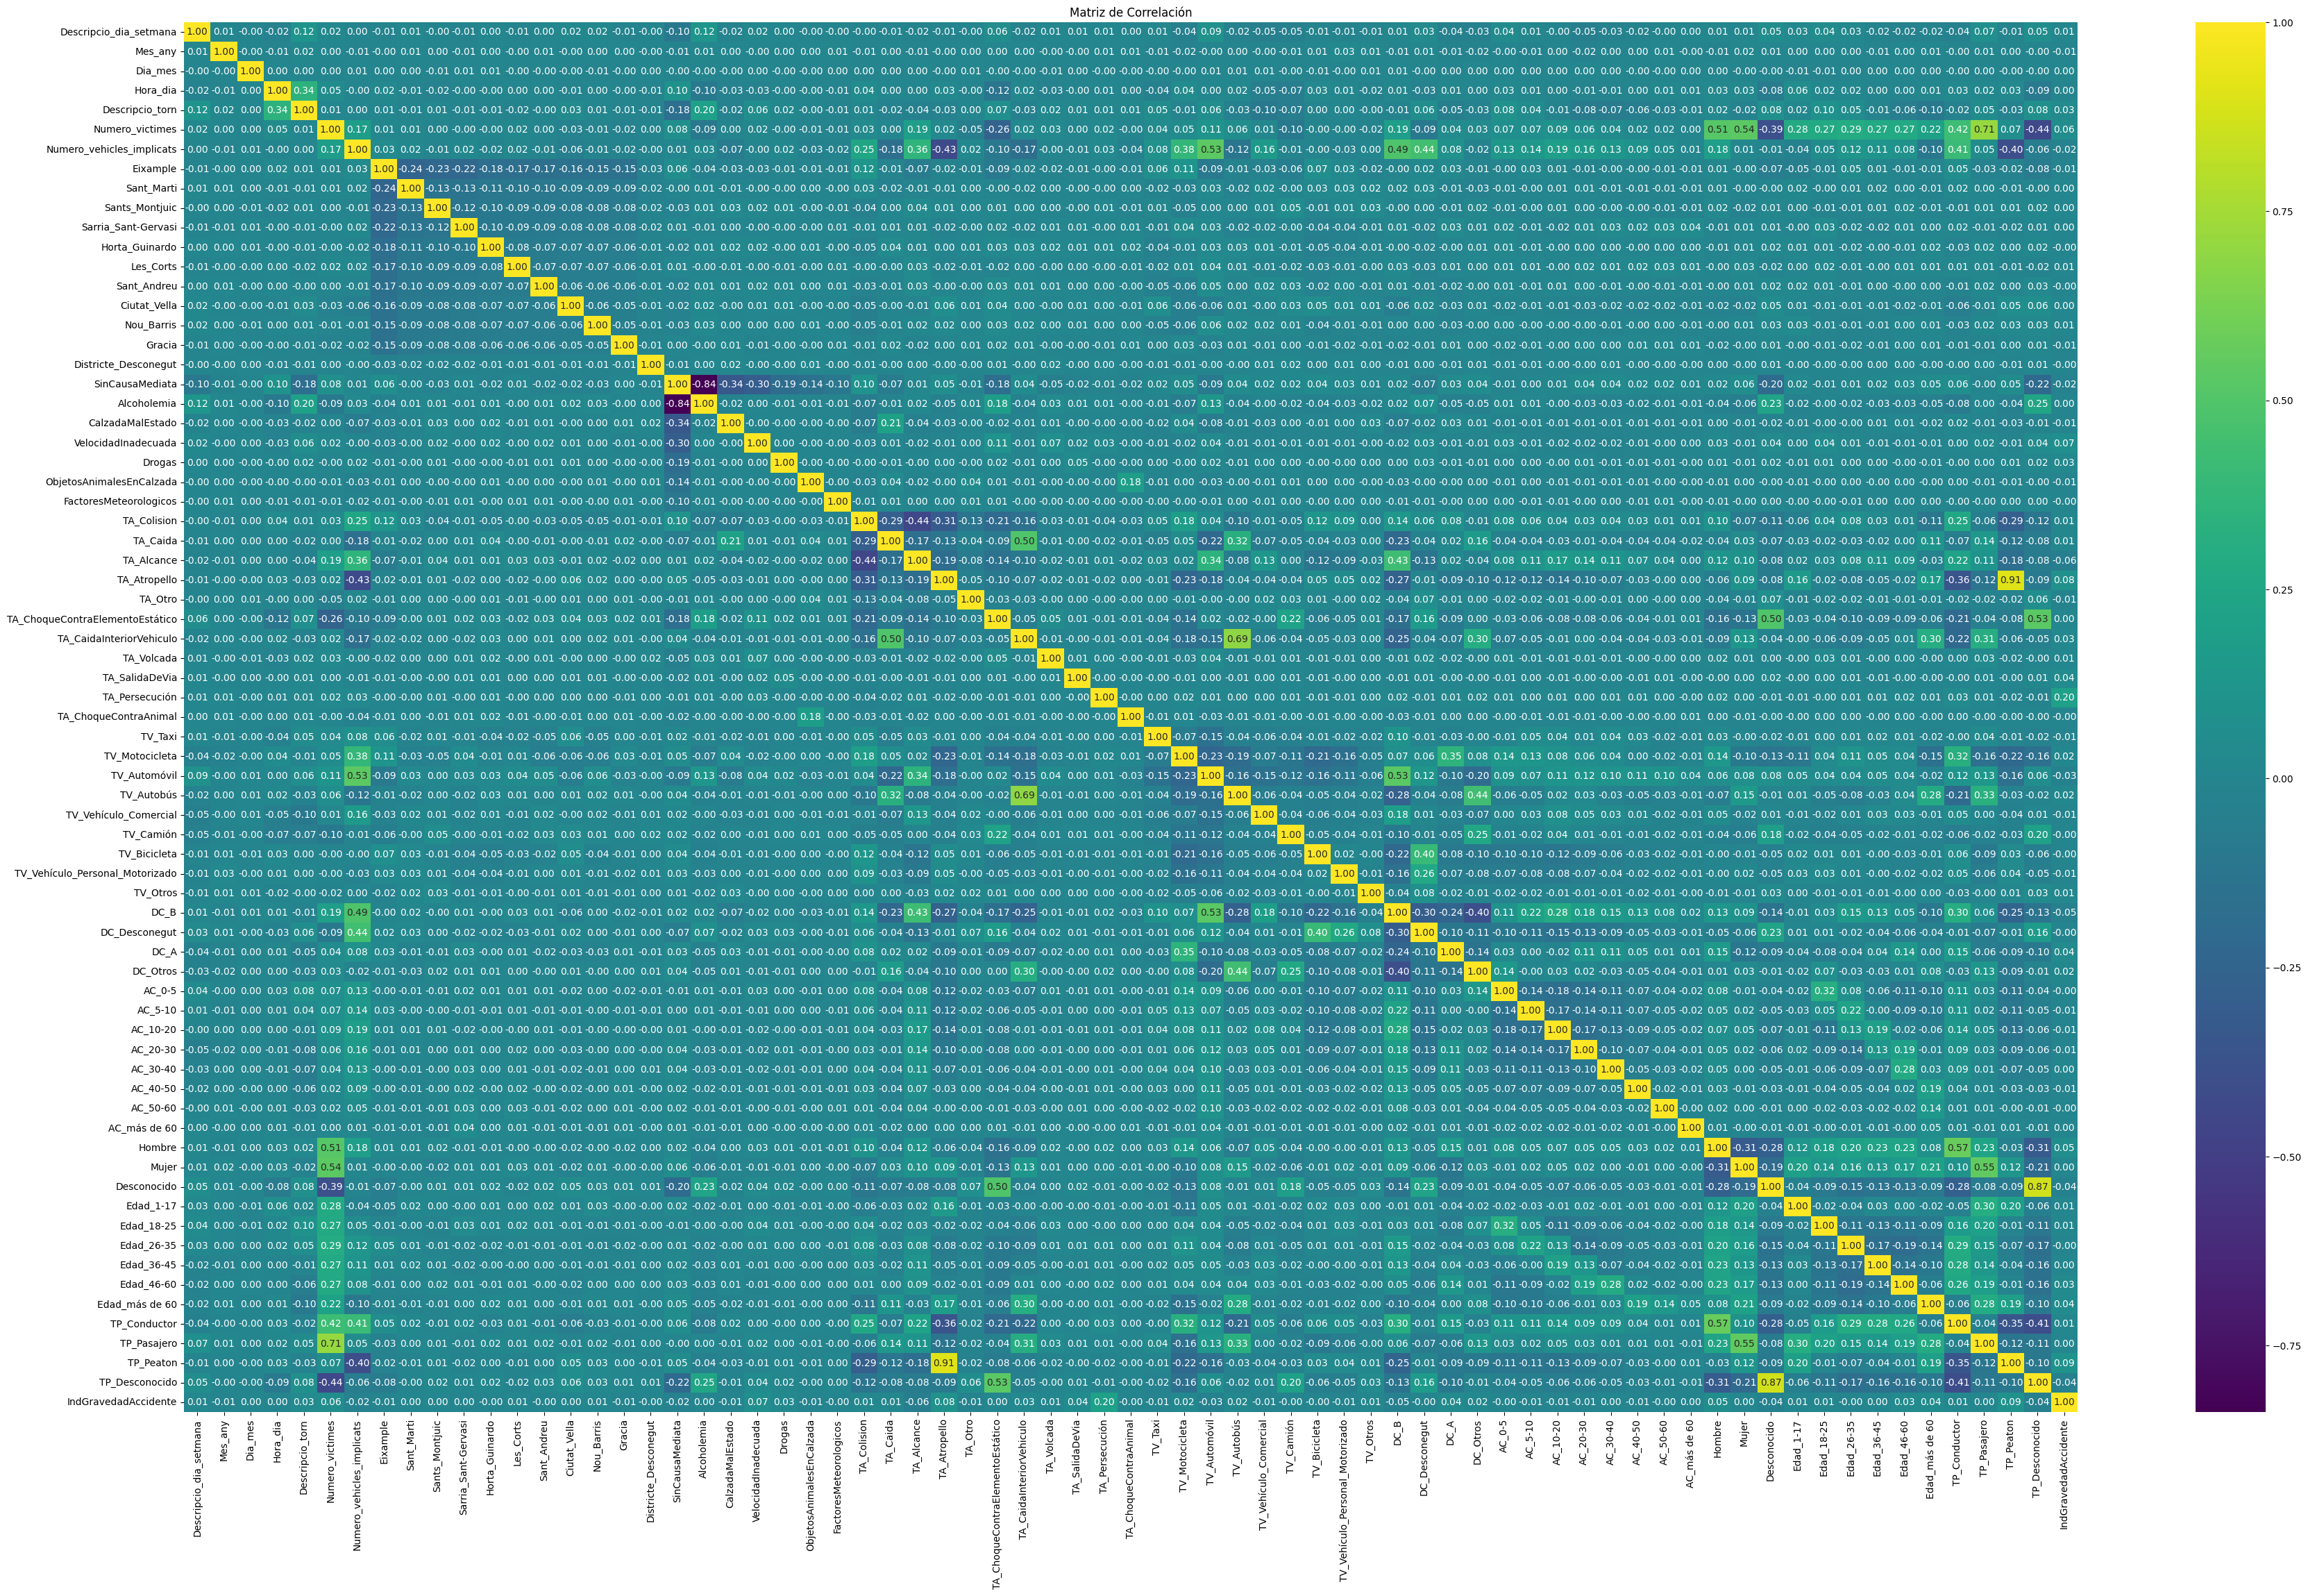

In [6]:
correlation_matrix = df_classification.corr()
plt.figure(figsize=(44, 26))
sns.heatmap(correlation_matrix, annot=True, cmap="viridis", fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

#### VIF

In [7]:
# pd.set_option('display.max_rows', None)

In [8]:
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = df_classification.columns
vif_data["VIF"] = [variance_inflation_factor(df_classification.values, i) for i in range(df_classification.shape[1])]

vif_data

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
0,Descripcio_dia_setmana,1.049470
1,Mes_any,1.005118
2,Dia_mes,1.001028
3,Hora_dia,1.216084
4,Descripcio_torn,1.307505
...,...,...
66,TP_Conductor,inf
67,TP_Pasajero,inf
68,TP_Peaton,inf
69,TP_Desconocido,inf


In [9]:
# Eliminar las columnas con VIF elevado
df_classification.drop(columns=['Eixample', 'Numero_vehicles_implicats', 'DC_B',
                                'TP_Conductor', 'TV_Automóvil', 'SinCausaMediata', 'Numero_victimes'], inplace = True)

.

In [10]:
#df_classification = df_classification.drop(columns=['Districte_Desconegut', 'DC_Desconegut', 'Desconocido', 'TP_Desconocido'])

## Splitting the Dataset

In [11]:
# Dividir los datos en conjuntos de entrenamiento y prueba
features = [x for x in df_classification.columns if x not in 'IndGravedadAccidente']
X_train, X_test, y_train, y_test = train_test_split(df_classification[features], df_classification['IndGravedadAccidente'], test_size=0.2, random_state=42)

print(f'train samples: {len(X_train)}')
print(f'validation samples: {len(X_test)}')
print(f'target proportion: {sum(y_train)/len(y_train):.4f}')

# Calcular el valor de scale_pos_weight
scale_pos_weight = ((len(y_train) - y_train.sum()) / (y_train.sum()))

train samples: 49846
validation samples: 12462
target proportion: 0.0229


### Estandarizar

In [12]:
# Inicializar el StandardScaler
scaler = StandardScaler()

# Estandarizar las columnas en X_train
X_train = scaler.fit_transform(X_train)

# Aplicar la misma transformación a X_test
X_test = scaler.transform(X_test)

## XGBoost

In [13]:
n = int(len(X_train)*0.8) # 80% to train and 20% to eval

X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], y_train[:n], y_train[n:]

### Primer modelo

In [14]:
xgb_model = XGBClassifier(n_estimators=5000, learning_rate=0.1, verbosity=1, random_state=42, scale_pos_weight=scale_pos_weight)
xgb_model.fit(X_train_fit, y_train_fit, eval_set=[(X_train_eval, y_train_eval)], early_stopping_rounds=10)

print(f'\nBest iteration: {xgb_model.best_iteration}')

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.66578
[1]	validation_0-logloss:0.64556
[2]	validation_0-logloss:0.62897
[3]	validation_0-logloss:0.61493
[4]	validation_0-logloss:0.60247
[5]	validation_0-logloss:0.59174
[6]	validation_0-logloss:0.58328
[7]	validation_0-logloss:0.57546
[8]	validation_0-logloss:0.56863
[9]	validation_0-logloss:0.56143
[10]	validation_0-logloss:0.55541
[11]	validation_0-logloss:0.54998
[12]	validation_0-logloss:0.54513
[13]	validation_0-logloss:0.54100
[14]	validation_0-logloss:0.53542
[15]	validation_0-logloss:0.53211
[16]	validation_0-logloss:0.52769
[17]	validation_0-logloss:0.52498
[18]	validation_0-logloss:0.52122
[19]	validation_0-logloss:0.51861
[20]	validation_0-logloss:0.51529
[21]	validation_0-logloss:0.50996
[22]	validation_0-logloss:0.50683
[23]	validation_0-logloss:0.50336
[24]	validation_0-logloss:0.50075
[25]	validation_0-logloss:0.49688
[26]	validation_0-logloss:0.49298
[27]	validation_0-logloss:0.48897
[28]	validation_0-logloss:0.48728
[29]	validation_0-loglos

In [15]:
# Calcular recall y F1-score para los datos de entrenamiento
train_recall = recall_score(y_train, xgb_model.predict(X_train))
train_f1score = f1_score(y_train, xgb_model.predict(X_train))

# Calcular recall y F1-score para los datos de prueba
test_recall = recall_score(y_test, xgb_model.predict(X_test))
test_f1score = f1_score(y_test, xgb_model.predict(X_test))

# Imprimir los resultados
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),y_train):.4f}\n\tRecall: {train_recall:.4f}\n\tF1-score: {train_f1score:.4f}")
print(f"Metrics test:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_test),y_test):.4f}\n\tRecall: {test_recall:.4f}\n\tF1-score: {test_f1score:.4f}")

Metrics train:
	Accuracy score: 0.9859
	Recall: 0.8434
	F1-score: 0.7334
Metrics test:
	Accuracy score: 0.9636
	Recall: 0.1667
	F1-score: 0.1530


### Segundo modelo

In [16]:
# Inicializar el modelo XGBoost con los hiperparámetros especificados
xgb_model = XGBClassifier(
    n_estimators=5000,
    learning_rate=0.1,
    verbosity=1,
    random_state=42,
    scale_pos_weight=((len(y_train_fit) - y_train_fit.sum()) / (y_train_fit.sum())),
    max_depth=5,
    max_leaves=4,
    min_child_weight=2,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    alpha=0
)

# Entrenar el modelo con los datos de entrenamiento y evaluar con el conjunto de evaluación
xgb_model.fit(X_train_fit, y_train_fit, eval_set=[(X_train_eval, y_train_eval)], early_stopping_rounds=10)

print(f'\nBest iteration: {xgb_model.best_iteration}')

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.68324
[1]	validation_0-logloss:0.67023
[2]	validation_0-logloss:0.65912
[3]	validation_0-logloss:0.65039
[4]	validation_0-logloss:0.64525
[5]	validation_0-logloss:0.63761
[6]	validation_0-logloss:0.63431
[7]	validation_0-logloss:0.63039
[8]	validation_0-logloss:0.62511
[9]	validation_0-logloss:0.62091
[10]	validation_0-logloss:0.61685
[11]	validation_0-logloss:0.61279
[12]	validation_0-logloss:0.61030
[13]	validation_0-logloss:0.60896
[14]	validation_0-logloss:0.60667
[15]	validation_0-logloss:0.60328
[16]	validation_0-logloss:0.60005
[17]	validation_0-logloss:0.59722
[18]	validation_0-logloss:0.59578
[19]	validation_0-logloss:0.59428
[20]	validation_0-logloss:0.59256
[21]	validation_0-logloss:0.59033
[22]	validation_0-logloss:0.58703
[23]	validation_0-logloss:0.58417
[24]	validation_0-logloss:0.58160
[25]	validation_0-logloss:0.57936
[26]	validation_0-logloss:0.57714
[27]	validation_0-logloss:0.57632
[28]	validation_0-logloss:0.57457
[29]	validation_0-loglos

In [17]:
# Calcular recall y F1-score para los datos de entrenamiento
train_recall = recall_score(y_train, xgb_model.predict(X_train))
train_f1score = f1_score(y_train, xgb_model.predict(X_train))

# Calcular recall y F1-score para los datos de prueba
test_recall = recall_score(y_test, xgb_model.predict(X_test))
test_f1score = f1_score(y_test, xgb_model.predict(X_test))

# Imprimir los resultados
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),y_train):.4f}\n\tRecall: {train_recall:.4f}\n\tF1-score: {train_f1score:.4f}")
print(f"Metrics test:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_test),y_test):.4f}\n\tRecall: {test_recall:.4f}\n\tF1-score: {test_f1score:.4f}")

Metrics train:
	Accuracy score: 0.7413
	Recall: 0.7725
	F1-score: 0.1205
Metrics test:
	Accuracy score: 0.7413
	Recall: 0.7602
	F1-score: 0.1039


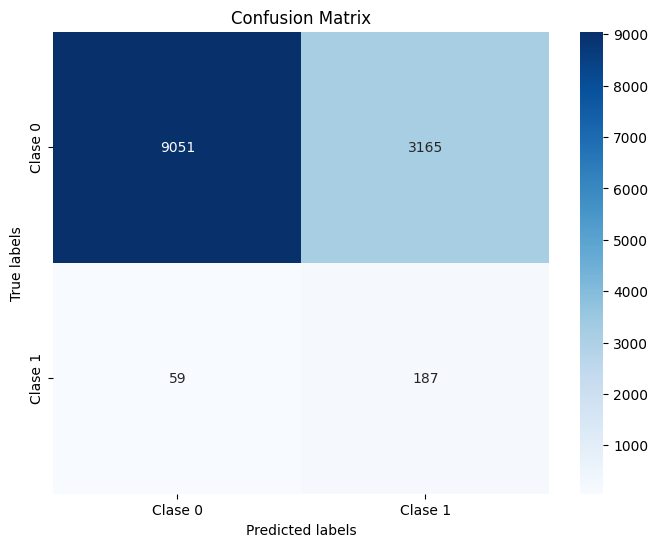

In [18]:
# Obtener las predicciones del modelo en los datos de prueba
y_pred = xgb_model.predict(X_test)
#y_pred_binary = (y_pred > 0.5).astype("int32")  # Convertir las probabilidades en clases binarias

# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Define las etiquetas de las clases
class_labels = ["Clase 0", "Clase 1"]

# Crea la figura y los ejes
plt.figure(figsize=(8, 6))

# Crea la matriz de confusión
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

# Añade etiquetas y título
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

<Figure size 1000x2000 with 0 Axes>

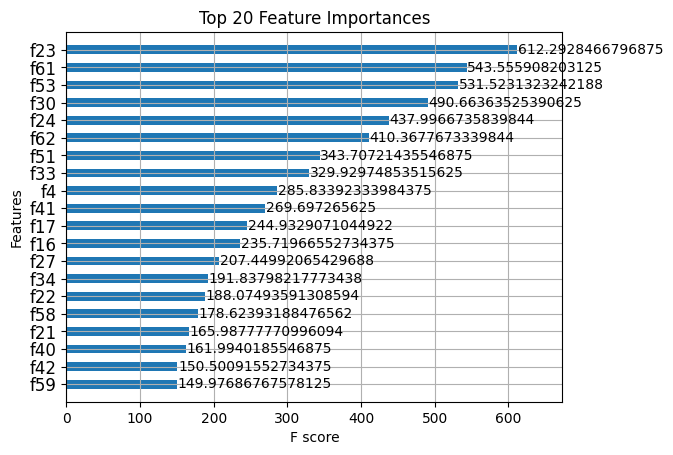

In [19]:
# Ajustar el tamaño del gráfico
plt.figure(figsize=(10, 20))

# Plot de importancia de características horizontal, mostrando solo las top 20
plot_importance(xgb_model, max_num_features=20, importance_type='gain', title='Top 20 Feature Importances', height=0.5)
plt.rcParams.update({'axes.labelsize': 'large'})

# Rotar las etiquetas de los ejes y ajustar el tamaño de las etiquetas
plt.yticks(fontsize=12)

# Mostrar el gráfico
plt.show()

<ipython-input-20-35e33cfb2ffb>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette=palette)


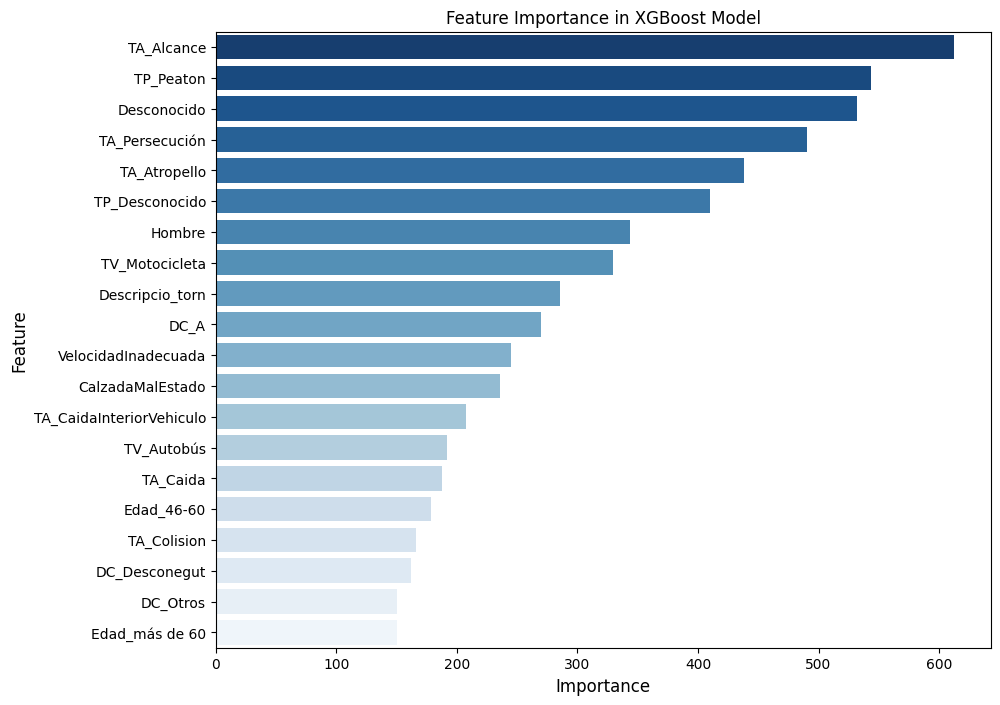

In [20]:
# Extraer la importancia de las características
importance = xgb_model.get_booster().get_score(importance_type='gain')

# Crear un dataframe con los nombres reales de las características
feature_map = {f'f{i}': feature for i, feature in enumerate(df_classification.columns)}

# Crear un dataframe para la importancia de las características
importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])

# Mapear las etiquetas a los nombres reales
importance_df['Feature'] = importance_df['Feature'].map(feature_map)

# Ordenar por importancia
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Ajustar el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Plotear las top 20 características más importantes
top_features = importance_df.head(20)

# Utilizar la paleta 'Reds' invertida
palette = sns.color_palette("Blues", n_colors=20)[::-1]

sns.barplot(x='Importance', y='Feature', data=top_features, palette=palette)
plt.title('Feature Importance in XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Tercer modelo

Con balanceo de clases

In [21]:
# Balancear las clases con SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_fit, y_train_fit)

In [22]:
# Crear una instancia del modelo XGBoost sin scale_pos_weight
xgb_model = XGBClassifier(
    n_estimators=5000,
    learning_rate=0.1,
    verbosity=1,
    random_state=42,
    max_depth=5,
    max_leaves=4,
    min_child_weight=2,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    alpha=0
)

# Ajustar el modelo con los datos balanceados
xgb_model.fit(X_train_balanced, y_train_balanced, eval_set=[(X_train_eval, y_train_eval)], early_stopping_rounds=50, verbose=True)
print(f'\nBest iteration: {xgb_model.best_iteration}')

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.67333
[1]	validation_0-logloss:0.65342
[2]	validation_0-logloss:0.63837
[3]	validation_0-logloss:0.62655
[4]	validation_0-logloss:0.61623
[5]	validation_0-logloss:0.60727
[6]	validation_0-logloss:0.59452
[7]	validation_0-logloss:0.58432
[8]	validation_0-logloss:0.57745
[9]	validation_0-logloss:0.56454
[10]	validation_0-logloss:0.55307
[11]	validation_0-logloss:0.54316
[12]	validation_0-logloss:0.53800
[13]	validation_0-logloss:0.52970
[14]	validation_0-logloss:0.52396
[15]	validation_0-logloss:0.51952
[16]	validation_0-logloss:0.51059
[17]	validation_0-logloss:0.50112
[18]	validation_0-logloss:0.49815
[19]	validation_0-logloss:0.49339
[20]	validation_0-logloss:0.48332
[21]	validation_0-logloss:0.47548
[22]	validation_0-logloss:0.46780
[23]	validation_0-logloss:0.46113
[24]	validation_0-logloss:0.45868
[25]	validation_0-logloss:0.45216
[26]	validation_0-logloss:0.44620
[27]	validation_0-logloss:0.43986
[28]	validation_0-logloss:0.43046
[29]	validation_0-loglos

In [23]:
# Realizar predicciones con el conjunto de prueba
y_pred = xgb_model.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Informe de clasificación
class_report = classification_report(y_test, y_pred)
print('Classification Report:')
print(class_report)

Accuracy: 0.98
Confusion Matrix:
[[12207     9]
 [  220    26]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     12216
           1       0.74      0.11      0.19       246

    accuracy                           0.98     12462
   macro avg       0.86      0.55      0.59     12462
weighted avg       0.98      0.98      0.97     12462



<Figure size 1000x2000 with 0 Axes>

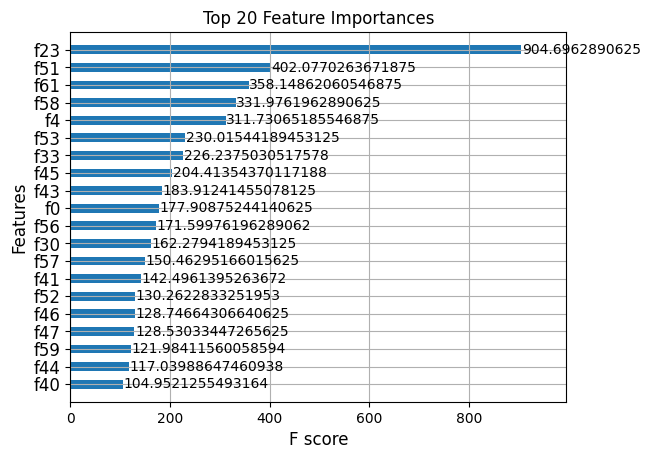

In [24]:
# Ajustar el tamaño del gráfico
plt.figure(figsize=(10, 20))

# Plot de importancia de características horizontal, mostrando solo las top 20
plot_importance(xgb_model, max_num_features=20, importance_type='gain', title='Top 20 Feature Importances', height=0.5)
plt.rcParams.update({'axes.labelsize': 'large'})

# Rotar las etiquetas de los ejes y ajustar el tamaño de las etiquetas
plt.yticks(fontsize=12)

# Mostrar el gráfico
plt.show()

<ipython-input-25-226c82f40972>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette=palette)
<ipython-input-25-226c82f40972>:22: UserWarning: The palette list has more values (20) than needed (10), which may not be intended.
  sns.barplot(x='Importance', y='Feature', data=top_features, palette=palette)


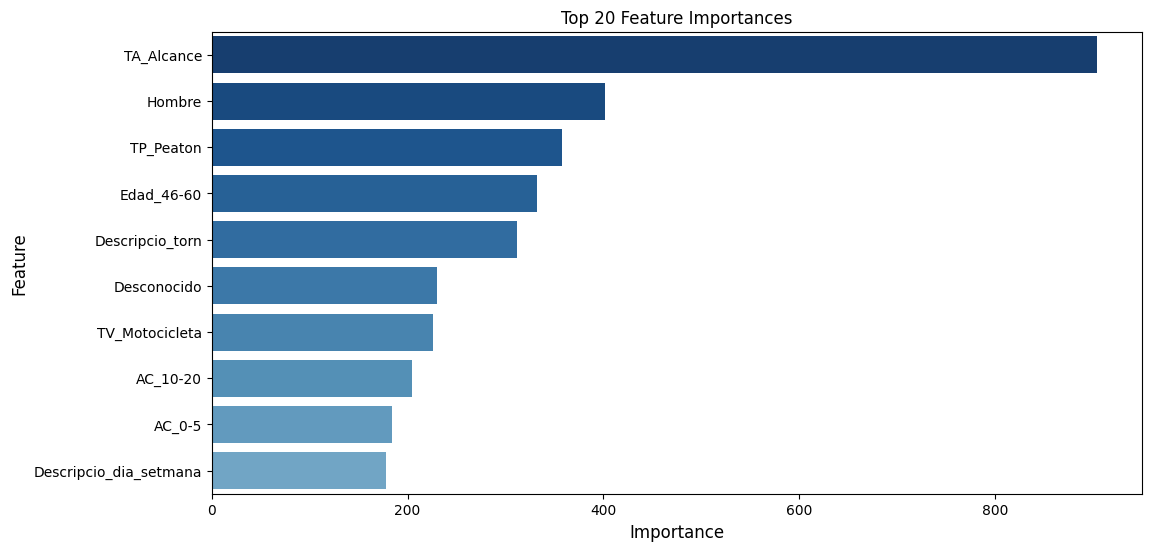

In [25]:
# Extraer la importancia de las características
importance = xgb_model.get_booster().get_score(importance_type='gain')

# Crear un dataframe con los nombres reales de las características
feature_map = {f'f{i}': feature for i, feature in enumerate(df_classification.columns)}

# Crear un dataframe para la importancia de las características
importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])

# Mapear las etiquetas a los nombres reales
importance_df['Feature'] = importance_df['Feature'].map(feature_map)

# Ordenar por importancia
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Ajustar el tamaño del gráfico
plt.figure(figsize=(12, 6))

# Plotear las top 20 características más importantes
top_features = importance_df.head(10)

sns.barplot(x='Importance', y='Feature', data=top_features, palette=palette)
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Neural Network

### Primer modelo

In [26]:
# Definir la arquitectura de la red neuronal
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Capa oculta con 64 neuronas y función de activación ReLU
    Dense(32, activation='relu'),  # Capa oculta con 32 neuronas y función de activación ReLU
    Dense(1, activation='sigmoid')  # Capa de salida con 1 neurona para la clasificación binaria y función de activación sigmoide
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall()])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluar el modelo
result = model.evaluate(X_test, y_test)
loss = result[0]
accuracy = result[1]
recall = result[2]

print(f'Loss: {loss}, Accuracy: {accuracy}, Recall: {recall}')


Epoch 1/50
1558/1558 [==============================] - 7s 3ms/step - loss: 0.1107 - accuracy: 0.9719 - recall: 0.0437 - val_loss: 0.0810 - val_accuracy: 0.9815 - val_recall: 0.0976
Epoch 2/50
1558/1558 [==============================] - 4s 2ms/step - loss: 0.0889 - accuracy: 0.9782 - recall: 0.0910 - val_loss: 0.0792 - val_accuracy: 0.9811 - val_recall: 0.0813
Epoch 3/50
1558/1558 [==============================] - 4s 2ms/step - loss: 0.0850 - accuracy: 0.9788 - recall: 0.1164 - val_loss: 0.0800 - val_accuracy: 0.9816 - val_recall: 0.1382
Epoch 4/50
1558/1558 [==============================] - 5s 3ms/step - loss: 0.0825 - accuracy: 0.9791 - recall: 0.1251 - val_loss: 0.0788 - val_accuracy: 0.9815 - val_recall: 0.1138
Epoch 5/50
1558/1558 [==============================] - 4s 2ms/step - loss: 0.0801 - accuracy: 0.9792 - recall: 0.1365 - val_loss: 0.0787 - val_accuracy: 0.9816 - val_recall: 0.1220
Epoch 6/50
1558/1558 [==============================] - 4s 2ms/step - loss: 0.0781 - accur

In [27]:
# Obtener las predicciones del modelo en los datos de entrenamiento y prueba
y_train_pred = model.predict(X_train)
y_train_pred_binary = (y_train_pred > 0.5).astype("int32")  # Convertir las probabilidades en clases binarias

y_test_pred = model.predict(X_test)
y_test_pred_binary = (y_test_pred > 0.5).astype("int32")  # Convertir las probabilidades en clases binarias

# Calcular el recall y el F1-score en los conjuntos de entrenamiento y prueba
train_recall = recall_score(y_train, y_train_pred_binary)
train_f1 = f1_score(y_train, y_train_pred_binary)

test_recall = recall_score(y_test, y_test_pred_binary)
test_f1 = f1_score(y_test, y_test_pred_binary)

print(f'Train Recall: {train_recall}')
print(f'Train F1-score: {train_f1}')

print(f'Test Recall: {test_recall}')
print(f'Test F1-score: {test_f1}')

390/390 [==============================] - 1s 2ms/step
Train Recall: 0.7961504811898513
Train F1-score: 0.8597071327350023
Test Recall: 0.16666666666666666
Test F1-score: 0.18303571428571427


### Segundo modelo

In [28]:
# Define la arquitectura de la red neuronal
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # Capa oculta con 128 neuronas y función de activación ReLU
    Dropout(0.5),  # Añade dropout para regularización
    Dense(64, activation='relu'),  # Capa oculta con 64 neuronas y función de activación ReLU
    Dropout(0.5),  # Añade dropout para regularización
    Dense(1, activation='sigmoid')  # Capa de salida con 1 neurona para la clasificación binaria y función de activación sigmoide
])

# Compila el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall()])

# Entrena el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evalúa el modelo
result = model.evaluate(X_test, y_test)
loss = result[0]
accuracy = result[1]
recall = result[2]

print(f'Loss: {loss}, Accuracy: {accuracy}, Recall: {recall}')


Epoch 1/50
1558/1558 [==============================] - 7s 4ms/step - loss: 0.1241 - accuracy: 0.9753 - recall_1: 0.0245 - val_loss: 0.0812 - val_accuracy: 0.9811 - val_recall_1: 0.1016
Epoch 2/50
1558/1558 [==============================] - 4s 3ms/step - loss: 0.1032 - accuracy: 0.9773 - recall_1: 0.0385 - val_loss: 0.0797 - val_accuracy: 0.9812 - val_recall_1: 0.0854
Epoch 3/50
1558/1558 [==============================] - 4s 3ms/step - loss: 0.0987 - accuracy: 0.9775 - recall_1: 0.0516 - val_loss: 0.0790 - val_accuracy: 0.9804 - val_recall_1: 0.0122
Epoch 4/50
1558/1558 [==============================] - 6s 4ms/step - loss: 0.0936 - accuracy: 0.9778 - recall_1: 0.0639 - val_loss: 0.0801 - val_accuracy: 0.9807 - val_recall_1: 0.0285
Epoch 5/50
1558/1558 [==============================] - 4s 3ms/step - loss: 0.0933 - accuracy: 0.9779 - recall_1: 0.0621 - val_loss: 0.0780 - val_accuracy: 0.9815 - val_recall_1: 0.1057
Epoch 6/50
1558/1558 [==============================] - 4s 3ms/step - 

In [29]:
# Obtiene las predicciones del modelo en los datos de entrenamiento y prueba
y_train_pred = model.predict(X_train)
y_train_pred_binary = (y_train_pred > 0.5).astype("int32")  # Convertir las probabilidades en clases binarias

y_test_pred = model.predict(X_test)
y_test_pred_binary = (y_test_pred > 0.5).astype("int32")  # Convertir las probabilidades en clases binarias

# Calcula el recall y el F1-score en los conjuntos de entrenamiento y prueba
train_recall = recall_score(y_train, y_train_pred_binary)
train_f1 = f1_score(y_train, y_train_pred_binary)

test_recall = recall_score(y_test, y_test_pred_binary)
test_f1 = f1_score(y_test, y_test_pred_binary)

print(f'Train Recall: {train_recall}')
print(f'Train F1-score: {train_f1}')

print(f'Test Recall: {test_recall}')
print(f'Test F1-score: {test_f1}')

390/390 [==============================] - 1s 1ms/step
Train Recall: 0.18110236220472442
Train F1-score: 0.30553505535055353
Test Recall: 0.11382113821138211
Test F1-score: 0.19858156028368795


## Logistic Regression

### Primer modelo

In [30]:
# Crear una instancia del modelo de regresión logística
logistic_model = LogisticRegression(max_iter=100000)

# Ajustar el modelo con los datos de entrenamiento
logistic_model.fit(X_train, y_train)

# Realizar predicciones con el conjunto de prueba
y_pred = logistic_model.predict(X_test)

In [31]:
# Calcular recall y F1-score para los datos de entrenamiento
train_recall = recall_score(y_train, logistic_model.predict(X_train))
train_f1score = f1_score(y_train, logistic_model.predict(X_train))

# Calcular recall y F1-score para los datos de prueba
test_recall = recall_score(y_test, logistic_model.predict(X_test))
test_f1score = f1_score(y_test, logistic_model.predict(X_test))

# Imprimir los resultados
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(logistic_model.predict(X_train),y_train):.4f}\n\tRecall: {train_recall:.4f}\n\tF1-score: {train_f1score:.4f}")
print(f"Metrics test:\n\tAccuracy score: {accuracy_score(logistic_model.predict(X_test),y_test):.4f}\n\tRecall: {test_recall:.4f}\n\tF1-score: {test_f1score:.4f}")

Metrics train:
	Accuracy score: 0.9775
	Recall: 0.0586
	F1-score: 0.1066
Metrics test:
	Accuracy score: 0.9811
	Recall: 0.0854
	F1-score: 0.1511


### Segundo modelo

In [32]:
# Crear una instancia del modelo de regresión logística con otro solver
logistic_model = LogisticRegression(solver='newton-cg')  # probar con 'liblinear', 'saga', 'newton-cg', etc.

# Ajustar el modelo con los datos de entrenamiento
logistic_model.fit(X_train, y_train)

# Realizar predicciones con el conjunto de prueba
y_pred = logistic_model.predict(X_test)

In [33]:
# Calcular recall y F1-score para los datos de entrenamiento
train_recall = recall_score(y_train, logistic_model.predict(X_train))
train_f1score = f1_score(y_train, logistic_model.predict(X_train))

# Calcular recall y F1-score para los datos de prueba
test_recall = recall_score(y_test, logistic_model.predict(X_test))
test_f1score = f1_score(y_test, logistic_model.predict(X_test))

# Imprimir los resultados
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(logistic_model.predict(X_train),y_train):.4f}\n\tRecall: {train_recall:.4f}\n\tF1-score: {train_f1score:.4f}")
print(f"Metrics test:\n\tAccuracy score: {accuracy_score(logistic_model.predict(X_test),y_test):.4f}\n\tRecall: {test_recall:.4f}\n\tF1-score: {test_f1score:.4f}")

Metrics train:
	Accuracy score: 0.9775
	Recall: 0.0586
	F1-score: 0.1066
Metrics test:
	Accuracy score: 0.9811
	Recall: 0.0854
	F1-score: 0.1511


## Light GVM

### Primer modelo

In [35]:
# Crear el dataset de LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Configurar los parámetros del modelo
params = {
    'objective': 'binary',
    'boosting': 'gbdt',
    'metric': 'binary_logloss',
    'scale_pos_weight': scale_pos_weight,
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'early_stopping_round': 10
}

# Entrenar el modelo
num_round = 1000
bst = lgb.train(params, train_data, num_boost_round=num_round, valid_sets=[test_data], valid_names=['validation'])

# Predicciones
## Predicciones para el conjunto de prueba
y_pred_test = bst.predict(X_test, num_iteration=bst.best_iteration)
y_pred_test_binary = [1 if x > 0.5 else 0 for x in y_pred_test]

## Predicciones para el conjunto de entrenamiento
y_pred_train = bst.predict(X_train, num_iteration=bst.best_iteration)
y_pred_train_binary = [1 if x > 0.5 else 0 for x in y_pred_train]

[LightGBM] [Info] Number of positive: 1143, number of negative: 48703
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.716146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 381
[LightGBM] [Info] Number of data points in the train set: 49846, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022931 -> initscore=-3.752084
[LightGBM] [Info] Start training from score -3.752084
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	validation's binary_logloss: 0.103475


In [37]:
# Evaluar el modelo para el conjunto de entrenamiento
print("Evaluación para el conjunto de entrenamiento:")
#print(classification_report(y_train, y_pred_train_binary))
train_accuracy = accuracy_score(y_train, y_pred_train_binary)
train_recall = recall_score(y_train, y_pred_train_binary)
train_f1 = f1_score(y_train, y_pred_train_binary)
print(f"Accuracy (train): {train_accuracy:.4f}")
print(f"Recall (train): {train_recall:.4f}")
print(f"F1 Score (train): {train_f1:.4f}")

# Evaluar el modelo para el conjunto de prueba
print("\nEvaluación para el conjunto de prueba:")
#print(classification_report(y_test, y_pred_test_binary))
test_accuracy = accuracy_score(y_test, y_pred_test_binary)
test_recall = recall_score(y_test, y_pred_test_binary)
test_f1 = f1_score(y_test, y_pred_test_binary)
print(f"Accuracy (test): {test_accuracy:.4f}")
print(f"Recall (test): {test_recall:.4f}")
print(f"F1 Score (test): {test_f1:.4f}")



Evaluación para el conjunto de entrenamiento:
Accuracy (train): 0.9771
Recall (train): 0.0000
F1 Score (train): 0.0000

Evaluación para el conjunto de prueba:
Accuracy (test): 0.9803
Recall (test): 0.0000
F1 Score (test): 0.0000


### Segundo modelo

In [38]:
# Usar SMOTE para sobremuestrear la clase minoritaria en el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Crear el dataset de LightGBM
train_data = lgb.Dataset(X_train_smote, label=y_train_smote)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Configurar los parámetros del modelo
params = {
    'objective': 'binary',
    'boosting': 'gbdt',
    'metric': 'binary_logloss',
    'scale_pos_weight': scale_pos_weight,  # Aunque SMOTE equilibra las clases, mantenemos este ajuste
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'early_stopping_round': 10
}

# Entrenar el modelo
num_round = 100
bst = lgb.train(params, train_data, num_boost_round=num_round, valid_sets=[test_data], valid_names=['validation'])

# Predicciones
## Predicciones para el conjunto de prueba
y_pred_test = bst.predict(X_test, num_iteration=bst.best_iteration)
y_pred_test_binary = [1 if x > 0.5 else 0 for x in y_pred_test]

## Predicciones para el conjunto de entrenamiento
y_pred_train = bst.predict(X_train_smote, num_iteration=bst.best_iteration)
y_pred_train_binary = [1 if x > 0.5 else 0 for x in y_pred_train]

[LightGBM] [Info] Number of positive: 48703, number of negative: 48703
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13072
[LightGBM] [Info] Number of data points in the train set: 97406, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	validation's binary_logloss: 0.707723


In [39]:
# Evaluar el modelo para el conjunto de entrenamiento
print("Evaluación para el conjunto de entrenamiento:")
#print(classification_report(y_train_smote, y_pred_train_binary))
train_accuracy = accuracy_score(y_train_smote, y_pred_train_binary)
train_recall = recall_score(y_train_smote, y_pred_train_binary)
train_f1 = f1_score(y_train_smote, y_pred_train_binary)
print(f"Accuracy (train): {train_accuracy:.4f}")
print(f"Recall (train): {train_recall:.4f}")
print(f"F1 Score (train): {train_f1:.4f}")

# Evaluar el modelo para el conjunto de prueba
print("\nEvaluación para el conjunto de prueba:")
#print(classification_report(y_test, y_pred_test_binary))
test_accuracy = accuracy_score(y_test, y_pred_test_binary)
test_recall = recall_score(y_test, y_pred_test_binary)
test_f1 = f1_score(y_test, y_pred_test_binary)
print(f"Accuracy (test): {test_accuracy:.4f}")
print(f"Recall (test): {test_recall:.4f}")
print(f"F1 Score (test): {test_f1:.4f}")



Evaluación para el conjunto de entrenamiento:
Accuracy (train): 0.6923
Recall (train): 0.9984
F1 Score (train): 0.7644

Evaluación para el conjunto de prueba:
Accuracy (test): 0.3894
Recall (test): 0.9228
F1 Score (test): 0.0563


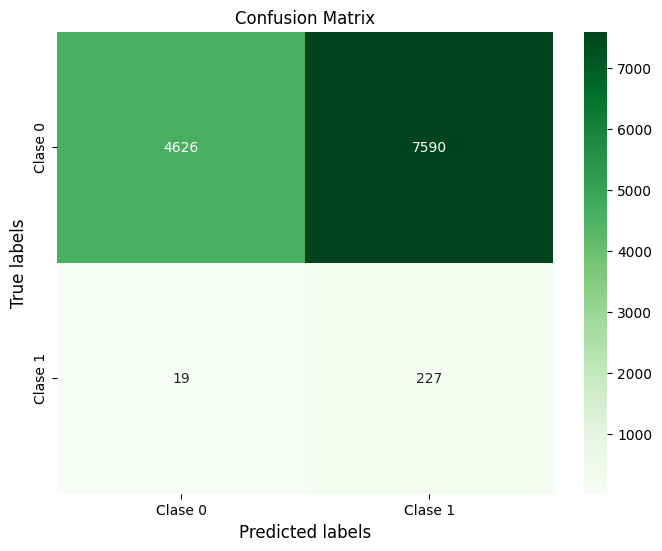

In [40]:
# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_test_binary)

# Define las etiquetas de las clases
class_labels = ["Clase 0", "Clase 1"]

# Crea la figura y los ejes
plt.figure(figsize=(8, 6))

# Crea la matriz de confusión
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=class_labels, yticklabels=class_labels)

# Añade etiquetas y título
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

<ipython-input-41-2026320ed682>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette=palette)


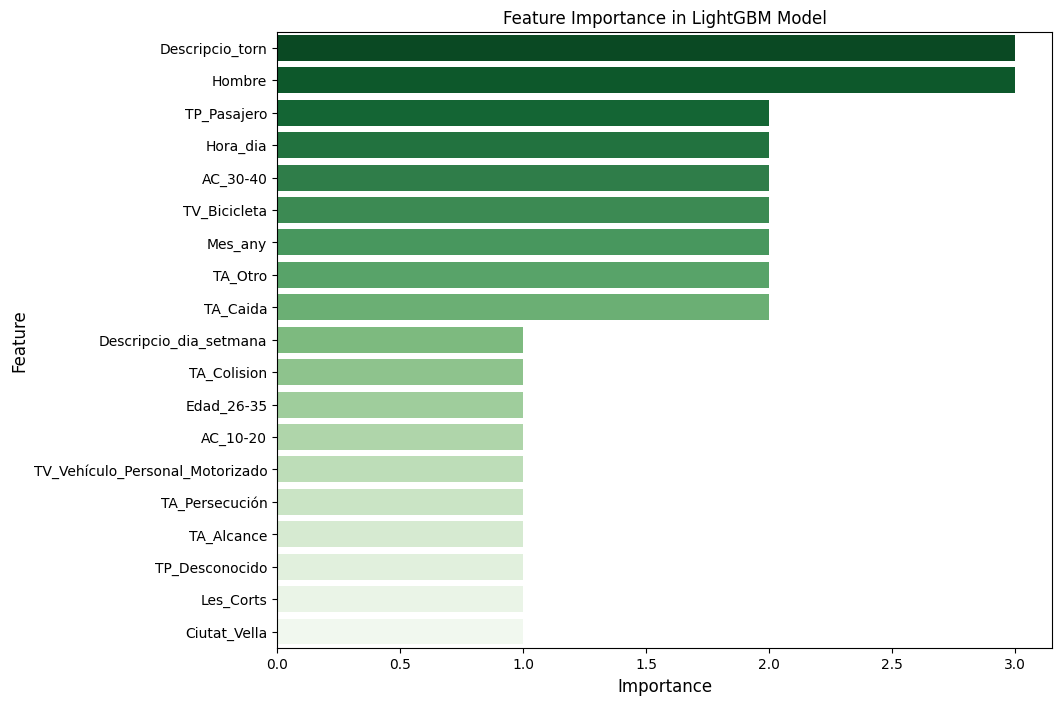

In [41]:
# Obtener la importancia de las características
feature_importance = bst.feature_importance()
feature_names = features

# Crear un DataFrame para la importancia de las características
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False).head(19)

palette = sns.color_palette("Greens", n_colors=19)[::-1]

# Plot de la importancia de las características usando seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette=palette)
plt.title('Feature Importance in LightGBM Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

[LightGBM] [Info] Number of positive: 48703, number of negative: 48703
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13072
[LightGBM] [Info] Number of data points in the train set: 97406, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's binary_logloss: 0.691873	validation's binary_logloss: 0.695351
Evaluación para el conjunto de prueba:
              precision    recall  f1-score   support

           0       1.00      0.30      0.46     12216
           1       0.03      0.98      0.05       246

    accuracy                           0.31     12462
   macro avg       0.51      0.64      0.26     12462
weighted avg  

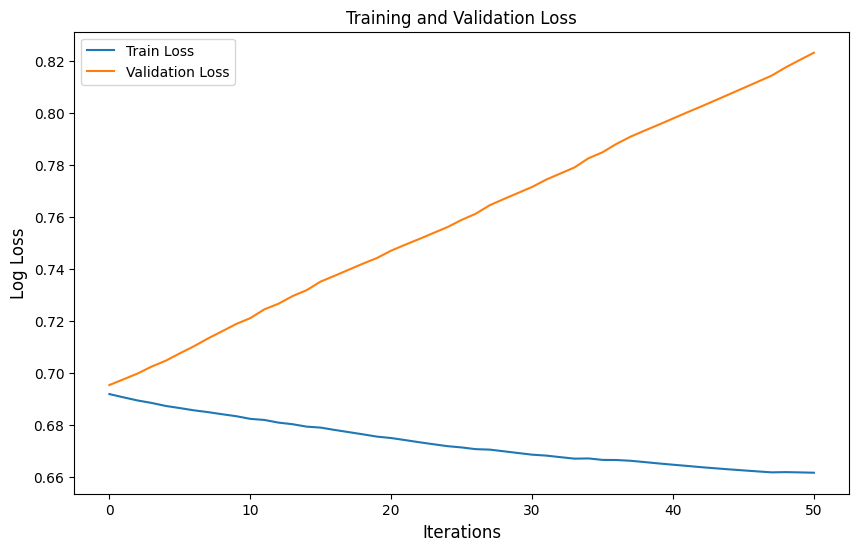

In [43]:
# Usar SMOTE para sobremuestrear la clase minoritaria en el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Crear el dataset de LightGBM
train_data = lgb.Dataset(X_train_smote, label=y_train_smote)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Configurar los parámetros del modelo ajustados
params = {
    'objective': 'binary',
    'boosting': 'gbdt',
    'metric': 'binary_logloss',
    'scale_pos_weight': scale_pos_weight,
    'num_leaves': 10,
    'learning_rate': 0.005,
    'feature_fraction': 0.8,
    'lambda_l1': 0.5,
    'lambda_l2': 0.5
}

# Crear diccionario para almacenar los resultados de entrenamiento
evals_result = {'train': [], 'validation': []}

# Definir un callback para capturar las métricas
def log_evaluation(period=1):
    def _callback(env):
        if period > 0 and env.iteration % period == 0:
            evals_result['train'].append(env.evaluation_result_list[0][2])
            evals_result['validation'].append(env.evaluation_result_list[1][2])
    return _callback

# Entrenar el modelo
num_round = 2000
bst = lgb.train(params, train_data, num_boost_round=num_round, valid_sets=[train_data, test_data], valid_names=['train', 'validation'], callbacks=[log_evaluation(), lgb.early_stopping(stopping_rounds=50)])

# Predicciones para el conjunto de prueba
y_pred_test = bst.predict(X_test, num_iteration=bst.best_iteration)
y_pred_test_binary = [1 if x > 0.5 else 0 for x in y_pred_test]

# Predicciones para el conjunto de entrenamiento
y_pred_train = bst.predict(X_train_smote, num_iteration=bst.best_iteration)
y_pred_train_binary = [1 if x > 0.5 else 0 for x in y_pred_train]

# Evaluar el modelo para el conjunto de prueba
print("Evaluación para el conjunto de prueba:")
print(classification_report(y_test, y_pred_test_binary))
test_accuracy = accuracy_score(y_test, y_pred_test_binary)
test_recall = recall_score(y_test, y_pred_test_binary)
test_f1 = f1_score(y_test, y_pred_test_binary)
print(f"Accuracy (test): {test_accuracy:.4f}")
print(f"Recall (test): {test_recall:.4f}")
print(f"F1 Score (test): {test_f1:.4f}")

# Evaluar el modelo para el conjunto de entrenamiento
print("Evaluación para el conjunto de entrenamiento:")
print(classification_report(y_train_smote, y_pred_train_binary))
train_accuracy = accuracy_score(y_train_smote, y_pred_train_binary)
train_recall = recall_score(y_train_smote, y_pred_train_binary)
train_f1 = f1_score(y_train_smote, y_pred_train_binary)
print(f"Accuracy (train): {train_accuracy:.4f}")
print(f"Recall (train): {train_recall:.4f}")
print(f"F1 Score (train): {train_f1:.4f}")

# Plot de la curva de pérdida
plt.figure(figsize=(10, 6))
plt.plot(evals_result['train'], label='Train Loss')
plt.plot(evals_result['validation'], label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
